# Carga de librerias necesarias

%pip install folium   
%pip install geopy   
%pip install geopandas   
%pip install dash-bootstrap-components   
%pip install dash   
%pip install tabulate

In [307]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker # per poder utilitzar FuncFormatter i aplicar format a la barra
import geopandas as gpd
import time
import folium
import os
import re
from mysql.connector import errorcode
from dotenv import load_dotenv # type: ignore # per dades accedir base dades
from datetime import datetime
from matplotlib.ticker import FuncFormatter # per poder utilitzar el separador de milersimport geopandas as gpd
from geopy.geocoders import Nominatim
from shapely.geometry import Point
from geopy.exc import GeocoderTimedOut
from folium.plugins import MarkerCluster
from tabulate import tabulate # para formato de una tabla
from scipy.stats import skew
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer

#Librería para gráficos interactivos en python
import plotly.graph_objects as go
import plotly.express as px

# Carregar credencials base de dades: arxiu .env

In [308]:
load_dotenv()

DB_HOST = os.getenv('host')
DB_USER = os.getenv('usuario')
DB_PASSWORD = os.getenv('clave')
DB_DATABASE = os.getenv('db')

# Conexion a MySQL para extraer tabla

In [309]:
try:
    # Intentar conectar a la base de datos
    cnx = mysql.connector.connect(
        host=DB_HOST,
        user=DB_USER,
        password=DB_PASSWORD,
        database=DB_DATABASE,
        charset='utf8mb4')
    
    tabla = "Tourist_Accommodation22042025"

    # Ejecutar consulta para obtener los datos
    mycursor = cnx.cursor(dictionary=True)  # Crear cursor habilitando diccionario
    mycursor.execute(f"SELECT * FROM {tabla}")
    df = pd.DataFrame(mycursor.fetchall())

    # Imprimir los primeros registros
    print(df.head(5))

except mysql.connector.Error as err:
    # Manejo de errores específicos
    if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Usuario o contraseña incorrectos")
    elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("La base de datos especificada no existe")
    else:
        print(f"Error inesperado: {err}")

finally:
    # Cerrar conexión
    try:
        if 'mycursor' in locals() and mycursor:
            mycursor.close()
        if 'cnx' in locals() and cnx.is_connected():
            cnx.close()
    except Exception as e:
        print(f"Error al cerrar la conexión: {e}")

   apartment_id                                               name  \
0         11964                                 A ROOM WITH A VIEW   
1         21853                               Bright and airy room   
2         32347  Explore Cultural Sights from a Family-Friendly...   
3         35379                  Double 02 CasanovaRooms Barcelona   
4         35801                  Can Torras Farmhouse Studio Suite   

                                         description  host_id  \
0  Private bedroom in our attic apartment. Right ...    45553   
1  We have a quiet and sunny room with a good vie...    83531   
2  Open French doors and step onto a plant-filled...   139939   
3  Room at a my apartment. Kitchen and 2 bathroom...   152232   
4  Lay in bed & watch sunlight change the mood of...   153805   

                neighbourhood_name neighbourhood_district        room_type  \
0                           Centro                   None     Private room   
1                         C�rmen

# Limpieza

## Comprobar dataset

In [310]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   apartment_id                 8000 non-null   int64  
 1   name                         7997 non-null   object 
 2   description                  7946 non-null   object 
 3   host_id                      8000 non-null   int64  
 4   neighbourhood_name           8000 non-null   object 
 5   neighbourhood_district       4861 non-null   object 
 6   room_type                    8000 non-null   object 
 7   accommodates                 8000 non-null   int64  
 8   bathrooms                    7957 non-null   object 
 9   bedrooms                     7961 non-null   object 
 10  beds                         7992 non-null   float64
 11  amenities_list               7983 non-null   object 
 12  price                        7829 non-null   float64
 13  minimum_nights    

## Cambio de tipo de datos de fechas

In [311]:
print(df[['first_review_date','last_review_date','insert_date']])

     first_review_date last_review_date insert_date
0           02/01/2010       05/09/2017  31/07/2018
1           10/10/2014       15/07/2018  10/01/2020
2           05/01/2011       22/07/2019  29/07/2019
3           13/03/2012       04/01/2020  10/01/2020
4           08/07/2011       08/08/2018  19/02/2019
...                ...              ...         ...
7995              None             None  16/10/2019
7996        17/03/2019       09/09/2020  31/01/2021
7997              None             None  24/04/2019
7998        04/03/2019       28/07/2019  12/08/2019
7999        21/04/2019       29/06/2019  31/08/2019

[8000 rows x 3 columns]


In [312]:
df['first_review_date'] = pd.to_datetime(df['first_review_date'], format='%d/%m/%Y')
df['last_review_date'] = pd.to_datetime(df['last_review_date'], format='%d/%m/%Y')
df['insert_date'] = pd.to_datetime(df['insert_date'], format='%d/%m/%Y')

df[['first_review_date','last_review_date','insert_date']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   first_review_date  6386 non-null   datetime64[ns]
 1   last_review_date   6385 non-null   datetime64[ns]
 2   insert_date        8000 non-null   datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 187.6 KB


## Duplicados

### Funcion de duplicados

In [313]:
def mantener_fecha_mas_reciente(df, columna_id, columna_fecha):
    """
    Elimina duplicados basados en un ID, manteniendo la fila con la fecha más reciente.
    
    Parámetros:
    df (DataFrame): El DataFrame que contiene los datos.
    columna_id (str): El nombre de la columna que identifica los duplicados.
    columna_fecha (str): El nombre de la columna que contiene las fechas.

    Retorna:
    DataFrame: Un nuevo DataFrame con los IDs únicos y sus fechas más recientes.
    """

    # Ordenar por fecha descendente
    df = df.sort_values(by=columna_fecha, ascending=False)

    # Eliminar duplicados manteniendo el más reciente
    df = df.drop_duplicates(subset=columna_id, keep='last')

    return df



#### Numero de registros duplicados

In [314]:
total_registros = len(df)
valores_unicos = df['apartment_id'].nunique()
duplicados = total_registros - valores_unicos
print(f"Registros duplicados: {duplicados}")
print(f"Registros que deberían quedar: {valores_unicos}")

Registros duplicados: 307
Registros que deberían quedar: 7693


### Ejecutar funcion al dataset con el ID del apartamento y la fecha de insersion 

In [315]:
df = mantener_fecha_mas_reciente(df, columna_id='apartment_id', columna_fecha='insert_date')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7693 entries, 3656 to 3006
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   apartment_id                 7693 non-null   int64         
 1   name                         7690 non-null   object        
 2   description                  7641 non-null   object        
 3   host_id                      7693 non-null   int64         
 4   neighbourhood_name           7693 non-null   object        
 5   neighbourhood_district       4669 non-null   object        
 6   room_type                    7693 non-null   object        
 7   accommodates                 7693 non-null   int64         
 8   bathrooms                    7656 non-null   object        
 9   bedrooms                     7657 non-null   object        
 10  beds                         7685 non-null   float64       
 11  amenities_list               7676 non-null   

## Normalizacion de "Amenities"

In [316]:
# Paso 1: Limpieza
df = df.dropna(subset=['amenities_list'])
df['amenities_list'] = df['amenities_list'].apply(
    lambda x: [a.strip() for a in x.split(',') if a.strip()])

def clean_amenity_list(lst):
    return [re.sub(r'[\[\]]', '', a.strip().lower()) for a in lst if a.strip()]

df['amenities_list'] = df['amenities_list'].apply(clean_amenity_list)

# Paso 2: Extraer amenities únicas
all_amenities = [item for sublist in df['amenities_list'] for item in sublist]
unique_amenities = sorted(set(all_amenities))

# Paso 3: Vectorizar
vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 4))
X = vectorizer.fit_transform(unique_amenities)

# Paso 4: Calcular similitud y distancia
similarity = cosine_similarity(X)
distance_matrix = np.clip(1 - similarity, 0, 1)

# Paso 5: Clustering con DBSCAN
clustering = DBSCAN(eps=0.3, min_samples=1, metric='precomputed')
labels = clustering.fit_predict(distance_matrix)

# Paso 6: Crear DataFrame y exportar
cluster_df = pd.DataFrame({'cluster_id': labels, 'amenity': unique_amenities
                           }).sort_values(by='cluster_id')

# Mostrar los grupos
cluster_view = defaultdict(list)
for label, amenity in zip(labels, unique_amenities):
    cluster_view[label].append(amenity)

# Contar cuántos grupos únicos hay
num_clusters = len(set(labels))
print(f"\nDe momento hay {len(unique_amenities)} comodidades únicas, dentro de {num_clusters} grupos provicionales.")

view_text = "\n".join(
    f"Grupo {cluster_id + 1}:\n" + ", ".join(sorted(group))
    for cluster_id, group in sorted(cluster_view.items()))

print(view_text)


De momento hay 245 comodidades únicas, dentro de 202 grupos provicionales.
Grupo 0:

Grupo 1:
24-hour check-in
Grupo 2:
40 hdtv
Grupo 3:
43 hdtv with netflix
Grupo 4:
accessible-height bed, accessible-height toilet
Grupo 5:
air conditioning, central air conditioning
Grupo 6:
amazon echo
Grupo 7:
baby bath
Grupo 8:
baby monitor
Grupo 9:
baby safety gates
Grupo 10:
babysitter recommendations
Grupo 11:
baking sheet
Grupo 12:
balcony, patio or balcony
Grupo 13:
barbecue utensils
Grupo 14:
bath towel
Grupo 15:
bathroom essentials, beach essentials, essentials
Grupo 16:
bathtub, bathtub with bath chair
Grupo 17:
bbq grill
Grupo 18:
beach view
Grupo 19:
beachfront
Grupo 20:
bed linens
Grupo 21:
bedroom comforts
Grupo 22:
bidet
Grupo 23:
bluetooth sound system, ikea nearby bluetooth sound system, sound system
Grupo 24:
body soap, rituals body soap
Grupo 25:
bread maker
Grupo 26:
breakfast, breakfast table
Grupo 27:
building staff
Grupo 28:
buzzer/wireless intercom
Grupo 29:
cable tv
Grupo 30:

#### Diccionario de equivalencias 

In [317]:
equivalencias = {
('24-hour check-in'): ['24-hour check-in', 'building staff', 'doorman', 'doorman entry', 'front desk/doorperson', 'host greets you'],
('air conditioning'): ['air conditioning', 'central air conditioning', 'central heating', 'heated floors', 'heating', 'ceiling fan', 'portable fans', 'portable heater'],
('baby essentials'): ['baby bath', 'baby essentials', 'baby monitor', 'baby safety gates', 'changing table', 'high chair', 'crib', 'pack u2019n play/travel crib', 'pack �n play/travel crib'],
('balcony'): ['balcony', 'patio or balcony', 'terrace'],
('barbecue utensils'): ['barbecue utensils', 'bbq grill'],
('bathroom essentials'): ['bath towel', 'bathroom essentials', 'beach essentials', 'essentials', 'body soap', 'conditioner', 'rituals body soap', 'rituals shampoo', 'shampoo', 'shower gel', 'toilet', 'toilet paper'],
('bathroom extras'): ['bidet', 'dryer', 'hair dryer', 'en suite bathroom', 'drying rack for clothing', 'heated towel rack', 'touchless faucets'],
('bathtub'): ['bathtub', 'hot tub', 'soaking tub'],
('beach view'): ['beach view', 'beachfront', 'waterfront'],
('bedroom estras'): ['bedroom comforts', 'bed linens', 'day bed', 'extra pillows and blankets'],
('sound system'): ['amazon echo', 'bluetooth sound system', 'ikea nearby bluetooth sound system', 'sound system'],
('buzzer/wireless intercom'): ['buzzer/wireless intercom'],
('cleaning before checkout'): ['cleaning before checkout', 'cleaning products'],
('storage'): ['clothing storage', 'clothing storage: closet', 'hangers', 'luggage dropoff allowed', 'standing valet'],
('coffee maker'): ['coffee maker', 'espresso machine', 'nespresso machine', 'pour over coffee', 'pour-over coffee'],
('elevator'): ['elevator', 'elevator in building'],
('internet'): ['ethernet connection', 'internet', 'wireless internet', 'wifi', 'wifi u2013 100 mbps', 'pocket wifi'],
('ev charger'): ['ev charger'],
('exercise equipment'): ['exercise equipment', 'gym'],
('family friendly'): ['babysitter recommendations', 'childrenu2019s books and toys', 'children�s books and toys', 'childrenu2019s dinnerware', 'children�s dinnerware', 'family/kid friendly', 'lock on bedroom door', 'table corner guards', 'window guards'],
('fire extinguisher'): ['fire extinguisher'],
('smoke detector'): ['carbon monoxide alarm', 'carbon monoxide detector', 'smoke alarm', 'smoke detector'],
('fireplace guards'): ['fireplace guards'],
('custom bed'): ['firm mattress', 'memory foam mattress', 'pillow-top mattress', 'murphy bed'],
('first aid kit'): ['first aid kit'],
('game console'): ['game console'],
('garden'): ['garden or backyard', 'shared garden or backyard'],
('indoor fireplace'): ['indoor fireplace'],
('ironing board'): ['iron', 'ironing board'],
('kitchen'): ["chef's kitchen", 'full kitchen', 'kitchen', 'kitchenette'],
('kitchen essentials'): ['baking sheet', 'cooking basics', 'dishes and silverware', 'wine glasses', 'bread maker', 'dishwasher', 'freezer', 'microwave', 'mini fridge', 'refrigerator', 'rice maker', 'toaster', 'hot water', 'hot water kettle'],
('dining area'): ['breakfast', 'breakfast table', 'dining area', 'dining table', 'formal dining area', 'outdoor dining area'],
('lake access'): ['lake access'],
('long term stays allowed'): ['long term stays allowed'],
('mosquito net'): ['mosquito net'],
('mountain view'): ['mountain view'],
('mudroom'): ['mudroom'],
('other'): ['other'],
('outdoor furniture'): ['hammock', 'outdoor furniture', 'outdoor seating', 'outlet covers', 'sun loungers'],
('oven'): ['convection oven', 'double oven', 'gas oven', 'oven', 'stainless steel oven', 'steam oven', 'warming drawer'],
('free parking'): ['free parking on premises', 'free driveway parking on premises u2013 1 space', 'free parking on street', 'free street parking', 'parking'],
('paid parking'): ['paid parking garage off premises', 'paid parking garage on premises', 'paid parking off premises', 'paid parking on premises'],
('pets allowed'): ['cat(s)', 'dog(s)', 'other pet(s)', 'pets allowed', 'pets live on this property'],
('pool'): ['pool', 'pool with pool hoist', 'pool toys', 'shared outdoor pool', 'shared pool'],
('private entrance'): ['private entrance'],
('private living room'): ['private living room'],
('room-darkening shades'): ['room-darkening shades'],
('security system'): ['keypad', 'lockbox', 'safety card', 'security system', 'smart lock'],
('self check-in'): ['self check-in'],
('shower'): ['outdoor shower', 'handheld shower head', 'rain shower', 'walk-in shower'],
('ski-in/ski-out'): ['ski in/ski out', 'ski-in/ski-out'],
('smoking allowed'): ['smoking allowed'],
('stair gates'): ['stair gates'],
('stove'): ['electric stove', 'stainless steel electric stove', 'stainless steel stove', 'stove'],
('suitable for events'): ['suitable for events'],
('translation missing:'): ['translation missing: en.hosting_amenity_49', 'translation missing: en.hosting_amenity_50'],
('trash can'): ['trash can'],
('tv'): ['40 hdtv', '43 hdtv with netflix', 'cable tv', 'dvd player', 'hbo go', 'netflix', 'smart tv', 'tv'],
('washer'): ['washer', 'washer u2013u00a0in unit', 'laundromat nearby'],
('well-lit path to entrance'): ['well-lit path to entrance'],
('wheelchair accessible'): ['disabled parking spot', 'electric profiling bed', 'flat', 'flat path to front door', 'flat path to guest entrance', 'ground floor access', 'step-free access', 'no stairs or steps to enter', 
                            'single level home', 'smooth pathway to front door', 'wheelchair accessible', 'wide doorway', 'wide entrance', 'wide entrance for guests', 'wide entryway', 'wide hallway clearance', 'wide hallways'],
('wheelchair accessible bathroom'): ['accessible-height toilet', 'bathtub with bath chair', 'extra space around shower and toilet', 'fixed grab bars for shower', 'fixed grab bars for shower & toilet', 'fixed grab bars for toilet', 
                                     'roll-in shower', 'shower chair', 'step-free shower', 'wide clearance to shower', 'wide clearance to shower & toilet', 'wide doorway to guest bathroom'],
('wheelchair accessible room'): ['accessible-height bed', 'extra space around bed', 'wide clearance to bed'],
('workspace'): ['dedicated workspace', 'laptop friendly workspace', 'laptop-friendly workspace', 'office', 'printer'],
}


#### Funcion que normaliza las amenities


In [318]:
def normalizar_amenities(amenities, equivalencias):
    if not amenities or not isinstance(amenities, str):
        return ''
    
    normalized = set()
    amenity_list = [a.strip().lower() for a in amenities.split(',') if a.strip()]

    for amenity in amenity_list:
        found = False
        for key, synonyms in equivalencias.items():
            if amenity in [s.lower() for s in synonyms]:
                normalized.add(key)
                found = True
                break
        if not found:
            normalized.add(amenity)  # Se conserva tal cual si no está en equivalencias
    
    return ', '.join(sorted(normalized))

#### Normalizamos las amenities y creamos una nueva columna con las amenities normalizadas 

In [319]:
# Aplicamos la función a la columna 'amenities'
df['amenities_normalized'] = df['amenities_list'].apply(lambda x: normalizar_amenities(', '.join(x), equivalencias))

# Mostramos el resultado
df[['amenities_normalized', 'amenities_list']].head()

,amenities_normalized,amenities_list
3656,"24-hour check-in, air conditioning, bathroom e...","[host greets you, extra pillows and blankets, ..."
5770,"24-hour check-in, baby essentials, balcony, ba...","[pack u2019n play/travel crib, patio or balcon..."
7894,"balcony, barbecue utensils, bathroom essential...","[refrigerator, long term stays allowed, washer..."
6749,"24-hour check-in, air conditioning, balcony, b...","[host greets you, cooking basics, garden or ba..."
4507,"air conditioning, baby essentials, balcony, ba...","[cooking basics, garden or backyard, bathtub, ..."


#### Mostrar la diferencia entre amenities unicas con y sin normalizar

In [320]:
# Extraer las amenidades originales únicas
amenidades_originales = set()
df['amenities_list'].dropna().apply(lambda lst: [amenidades_originales.add(i.strip().lower()) for i in lst])

# Extraer las amenidades normalizadas únicas
amenidades_normalizadas = set()
df['amenities_normalized'].dropna().apply(lambda lst: [amenidades_normalizadas.add(i.strip().lower()) for i in lst])

# Mostrar las amenidades únicas
print("Amenidades originales únicas:", len(amenidades_originales))
print("Amenidades normalizadas únicas:", len(amenidades_normalizadas))

Amenidades originales únicas: 245
Amenidades normalizadas únicas: 32


## Imputamos valor a los precios nulos

#### Exploración de los precios.

In [321]:
df[['apartment_id','price']].describe()

,apartment_id,price
count,7.676000e+03,7520.000000
mean,1.698858e+07,1006.823670
std,8.742635e+06,844.556271
min,1.196400e+04,60.000000
25%,1.078457e+07,450.000000
50%,1.811248e+07,750.000000
75%,2.365679e+07,1220.000000
max,3.242329e+07,6071.000000


Tenemos los precios de 6613 de los 6733 apartementos regristrados, con lo que 120 registros no tienen precio. O bien, lo que vendría siendo el 1.78% de los registros.

In [322]:
skewness = skew(df['price'].dropna())
print(f"La asimetría es de: {skewness:.2f}")

La asimetría es de: 2.08


Comprobamos el sesgo positivo en la distribución, donde vemos que la asimetría es positiva con una larga cola a la derecha, por lo que podemos intuir que posee muchos valores bajos y pocos muy altos.

Para corroborar esto vamos a graficar.

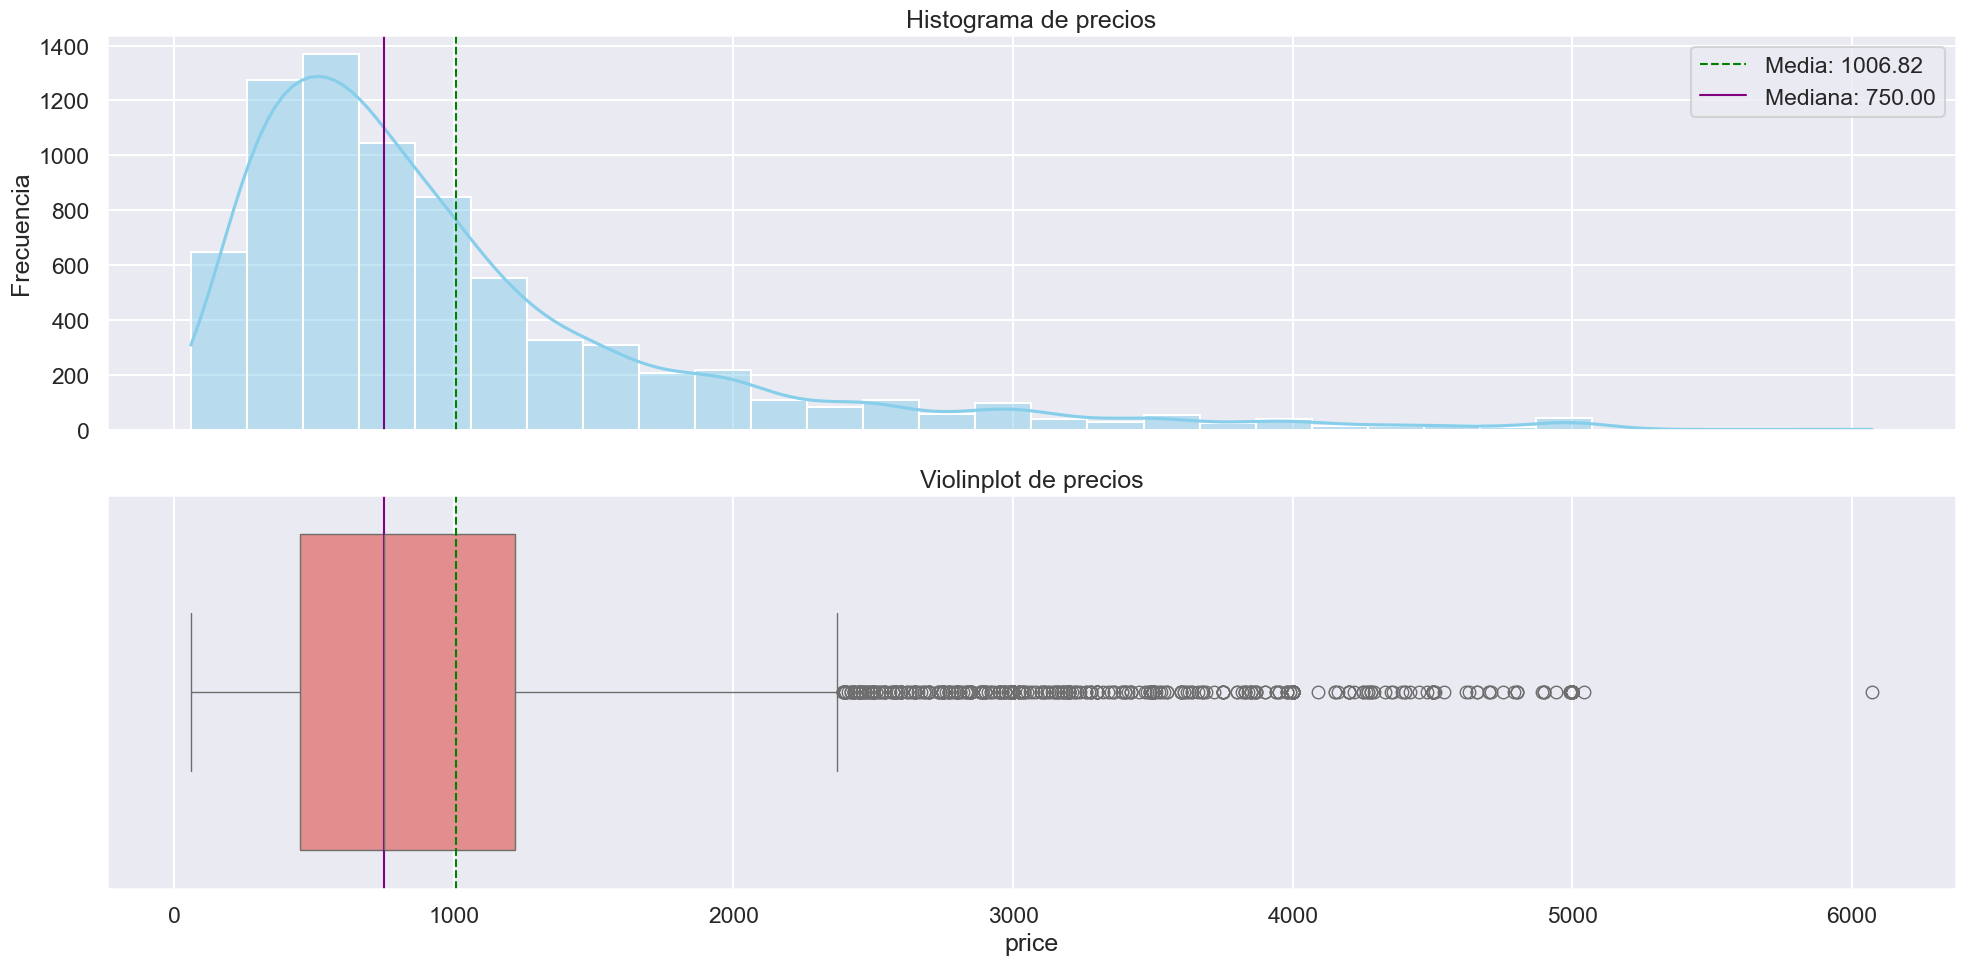

In [323]:
media_precio = df['price'].mean()
mediana_precio = df['price'].median()

sns.set_theme(context='talk', style='darkgrid')
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10), sharex=True)

sns.histplot(df['price'].dropna(), bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].axvline(media_precio, color='green', linestyle='--', linewidth=1.5, label=f'Media: {media_precio:.2f}')
axes[0].axvline(mediana_precio, color='purple', linestyle='-', linewidth=1.5, label=f'Mediana: {mediana_precio:.2f}')
axes[0].set_title('Histograma de precios')
axes[0].set_ylabel('Frecuencia')
axes[0].legend()

sns.boxplot(x=df['price'].dropna(), ax=axes[1], color='lightcoral')
axes[1].axvline(media_precio, color='green', linestyle='--', linewidth=1.5)
axes[1].axvline(mediana_precio, color='purple', linestyle='-', linewidth=1.5)
axes[1].set_title('Violinplot de precios')

plt.tight_layout()
plt.show()

Insights:
* Vemos que la distribución es asimétrica, con una cola larga de outliers a la derecha y con la mayoría de los precios hacia la izquierda. 
* Los outliers son de precios altos, más allá de 3.000 € y hasta 6.000 €.
* La mediana (750 €) está por debajo de la media (1009,92 €), lo cual confirma el sesgo positivo.

### Imputación
En este contexto, imputar por la media no sería lo ideal porque se vería muy influenciada por outliers.   
Por lo que optamos por imputar usando la mediana por ciudad, tipo de habitación y accomodates. Esto es simple pero efectivo.

In [324]:
df['price'] = df.groupby(['city', 'room_type', 'accommodates'])['price'].transform(
    lambda x: x.fillna(x.median()))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/nanfunctio

In [325]:
print(f'Hay {df["price"].isnull().sum()} precios con valores nulos')

Hay 8 precios con valores nulos


##### Filtramos los registros que siguen teniendo precios con valores nulos, y veremos que combinaciones no se pudieron imputar.

In [326]:
faltantes = df[df['price'].isnull()]

print(faltantes[['city', 'room_type', 'accommodates']].drop_duplicates())

           city        room_type  accommodates
4758   valencia     Private room             5
7181  barcelona       Hotel room             3
5459   mallorca  Entire home/apt            18
6756     madrid       Hotel room             4
4588    menorca  Entire home/apt            16
3247   mallorca  Entire home/apt            29
6234   mallorca  Entire home/apt            20
7675   mallorca  Entire home/apt            24


In [327]:
df['price'] = df.groupby(['city', 'room_type'])['price'].transform(
    lambda x: x.fillna(x.median()))

La primera ejecucion del código resulto en grupos que seguían teniedo valores nulos en 6 registros, por eso agregamos una segunda parte con un grupo más general para estos casos (sin tomar en cuenta los 'accommodates', solo ciudad y tipo de habitacion).

##### Segunda comprobación

In [328]:
print(f"Hay {df['price'].isnull().sum()} precios con valores nulos")

Hay 0 precios con valores nulos


# EDA's 

### EDA Operaciones

#### Funciones 

Función de generación de gráficos EDA Operaciones

In [329]:
def generar_graficos_disponibilidad(df):
    
    # Calcular la media de disponibilidad por ciudad
    disponibilidad_media = df.groupby('city')[['availability_30', 'availability_60', 'availability_90', 'availability_365']].mean()

    # Calcular el porcentaje de disponibilidad respecto al total de días posibles (30, 60, 90, 365)
    disponibilidad_media_porcentaje = disponibilidad_media.copy()

    # Calcular el porcentaje para cada columna de disponibilidad
    disponibilidad_media_porcentaje['availability_30'] = (disponibilidad_media['availability_30'] / 30) * 100
    disponibilidad_media_porcentaje['availability_60'] = (disponibilidad_media['availability_60'] / 60) * 100
    disponibilidad_media_porcentaje['availability_90'] = (disponibilidad_media['availability_90'] / 90) * 100
    disponibilidad_media_porcentaje['availability_365'] = (disponibilidad_media['availability_365'] / 365) * 100

    # Definir una paleta de colores coherente y con buen contraste para los gráficos
    colores = sns.color_palette("Set2", 4)  # Usamos una paleta de colores más saturados y contrastantes

    # Mostrar la media de disponibilidad por ciudad
    print("Media de disponibilidad por ciudad\n")
    print(disponibilidad_media)

    # Mostrar la media de disponibilidad en porcentaje por ciudad
    print("\nMedia de disponibilidad en porcentaje por ciudad\n")
    print(disponibilidad_media_porcentaje)

Funcion de distribución de la disponibilidad en los distintos períodos boxplot

In [330]:
def distribucion_disponibilidadboxplot(df, colores):
    # Crear la figura y la cuadrícula de subgráficos (2x2)
    fig, ax = plt.subplots(2, 2, figsize=(14, 12))  # 2 filas, 2 columnas
    
    # Lista de períodos de disponibilidad
    periodos = ['30', '60', '90', '365']
    disponibilidades = [df['availability_30'], df['availability_60'], df['availability_90'], df['availability_365']]
    
    for i, (periodo, disponibilidad) in enumerate(zip(periodos, disponibilidades)):
        fila = i // 2  # 0 o 1 (primera o segunda fila)
        columna = i % 2  # 0 o 1 (primera o segunda columna)
        
        # Seleccionar el eje correspondiente en la cuadrícula
        sns.boxplot(data=disponibilidad, color=colores[i], ax=ax[fila, columna])
        
        # Añadir título y etiquetas
        ax[fila, columna].set_title(f'Distribución de la Disponibilidad en los Últimos {periodo} Días', fontsize=12)
        ax[fila, columna].set_xlabel(f'Días Disponibles (Últimos {periodo} días)', fontsize=10)
        ax[fila, columna].set_ylabel('Días Disponibles', fontsize=10)
    
    # Ajustar el diseño para una mejor visualización
    plt.tight_layout()
    plt.show()

Funcion de  distribución de la disponibilidad en los distintos períodos barras

In [331]:
def distribucion_disponibilidadbarras(df, colores):
    # Crear la figura y la cuadrícula de subgráficos (2x2)
    fig, ax = plt.subplots(2, 2, figsize=(14, 12))  # 2 filas, 2 columnas
    
    # Lista de períodos de disponibilidad
    periodos = ['30', '60', '90', '365']
    disponibilidades = [df['availability_30'], df['availability_60'], df['availability_90'], df['availability_365']]
    
    for i, (periodo, disponibilidad) in enumerate(zip(periodos, disponibilidades)):
        fila = i // 2  # 0 o 1 (primera o segunda fila)
        columna = i % 2  # 0 o 1 (primera o segunda columna)
        
        # Seleccionar el eje correspondiente en la cuadrícula
        sns.histplot(disponibilidad, kde=True, color=colores[i], bins=30, ax=ax[fila, columna])
        
        # Añadir título y etiquetas
        ax[fila, columna].set_title(f'Distribución de la Disponibilidad en los Últimos {periodo} Días', fontsize=12)
        ax[fila, columna].set_xlabel(f'Días Disponibles (Últimos {periodo} días)', fontsize=10)
        ax[fila, columna].set_ylabel('Frecuencia', fontsize=10)
    
    # Ajustar el diseño para una mejor visualización
    plt.tight_layout()
    plt.show()

Funcion de mini gráficos para cada categoría de disponibilidad

In [332]:
def mini_graficos_categoria(disponibilidad_media, colores):
    # Segunda parte: Mini gráficos para cada categoría de disponibilidad (sin porcentajes)
    fig, ax = plt.subplots(2, 2, figsize=(14, 12))  # 2 filas, 2 columnas

    # Lista de categorías
    categorias = ['availability_30', 'availability_60', 'availability_90', 'availability_365']

    for i, categoria in enumerate(categorias):
        fila = i // 2  # 0 o 1 (primera o segunda fila)
        columna = i % 2  # 0 o 1 (primera o segunda columna)

        ax_sub = ax[fila, columna]
        # Para cada categoría, mostrar la disponibilidad media sin porcentajes
        disponibilidad_media[categoria].plot(kind='bar', ax=ax_sub, width=0.8, color=colores[i])

        ax_sub.set_title(f'Disponibilidad Media {categoria}', fontsize=12)
        ax_sub.set_xlabel('Ciudad', fontsize=10)
        ax_sub.set_ylabel(f'Media {categoria}', fontsize=10)
        ax_sub.set_xticklabels(disponibilidad_media.index, rotation=45, ha='right')

    # Ajustar el diseño para una mejor visualización
    plt.tight_layout()
    plt.show()

Funcion para cada ciudad con disponibilidad media en porcentaje

In [333]:
def graficos_por_ciudad(disponibilidad_media_porcentaje, colores):
    # Tercera parte: Gráficos de barras para cada ciudad con la disponibilidad media en porcentaje
    
    # Determinar el número de filas y columnas en la cuadrícula (4x4)
    num_ciudades = len(disponibilidad_media_porcentaje)
    filas = 2
    columnas = 4
    
    # Crear la figura y la cuadrícula de subgráficos
    fig, ax = plt.subplots(filas, columnas, figsize=(20, 10))  # Ajustamos el tamaño de la figura
    
    # Convertir la matriz de ejes en una lista para poder iterar sobre ella
    ax = ax.flatten()
    
    for i, ciudad in enumerate(disponibilidad_media_porcentaje.index):
        # Extraer los valores de disponibilidad para la ciudad
        ciudad_data = disponibilidad_media_porcentaje.loc[ciudad]

        # Seleccionar el eje correspondiente en la cuadrícula
        ax[i].bar(ciudad_data.index, ciudad_data.values, color=colores, width=0.8)

        # Añadir título y etiquetas
        ax[i].set_title(f'Disponibilidad Media (%)\npor Ciudad: {ciudad}', fontsize=12)
        ax[i].set_xlabel('Periodo (días)', fontsize=10)
        ax[i].set_ylabel('Disponibilidad Media (%)', fontsize=10)

        # Ajustar las etiquetas del eje X automáticamente
        ax[i].tick_params(axis='x', rotation=45)

        # Establecer los límites de los ejes
        ax[i].set_ylim(0, 100)  # Limitar el eje Y de 0 a 100
        ax[i].set_xlim(-0.5, 3.5)  # Limitar el eje X de 0 a 3 (porque tenemos 4 barras)

    # Ajustar el diseño para una mejor visualización
    plt.tight_layout()
    plt.show()

Funcion de las medias de todas las ciudades

In [334]:
def grafico_media_todas_las_ciudades(disponibilidad_media_porcentaje, colores):
    # Última parte: Gráfico de las medias de todas las ciudades
    plt.figure(figsize=(12, 8))
    disponibilidad_media_porcentaje.plot(kind='bar', figsize=(12, 8), color=colores)
    plt.title('Disponibilidad Media (%) de los Alojamientos Turísticos por Ciudad')
    plt.xlabel('Ciudad')
    plt.ylabel('Disponibilidad Media (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

#### Graficos

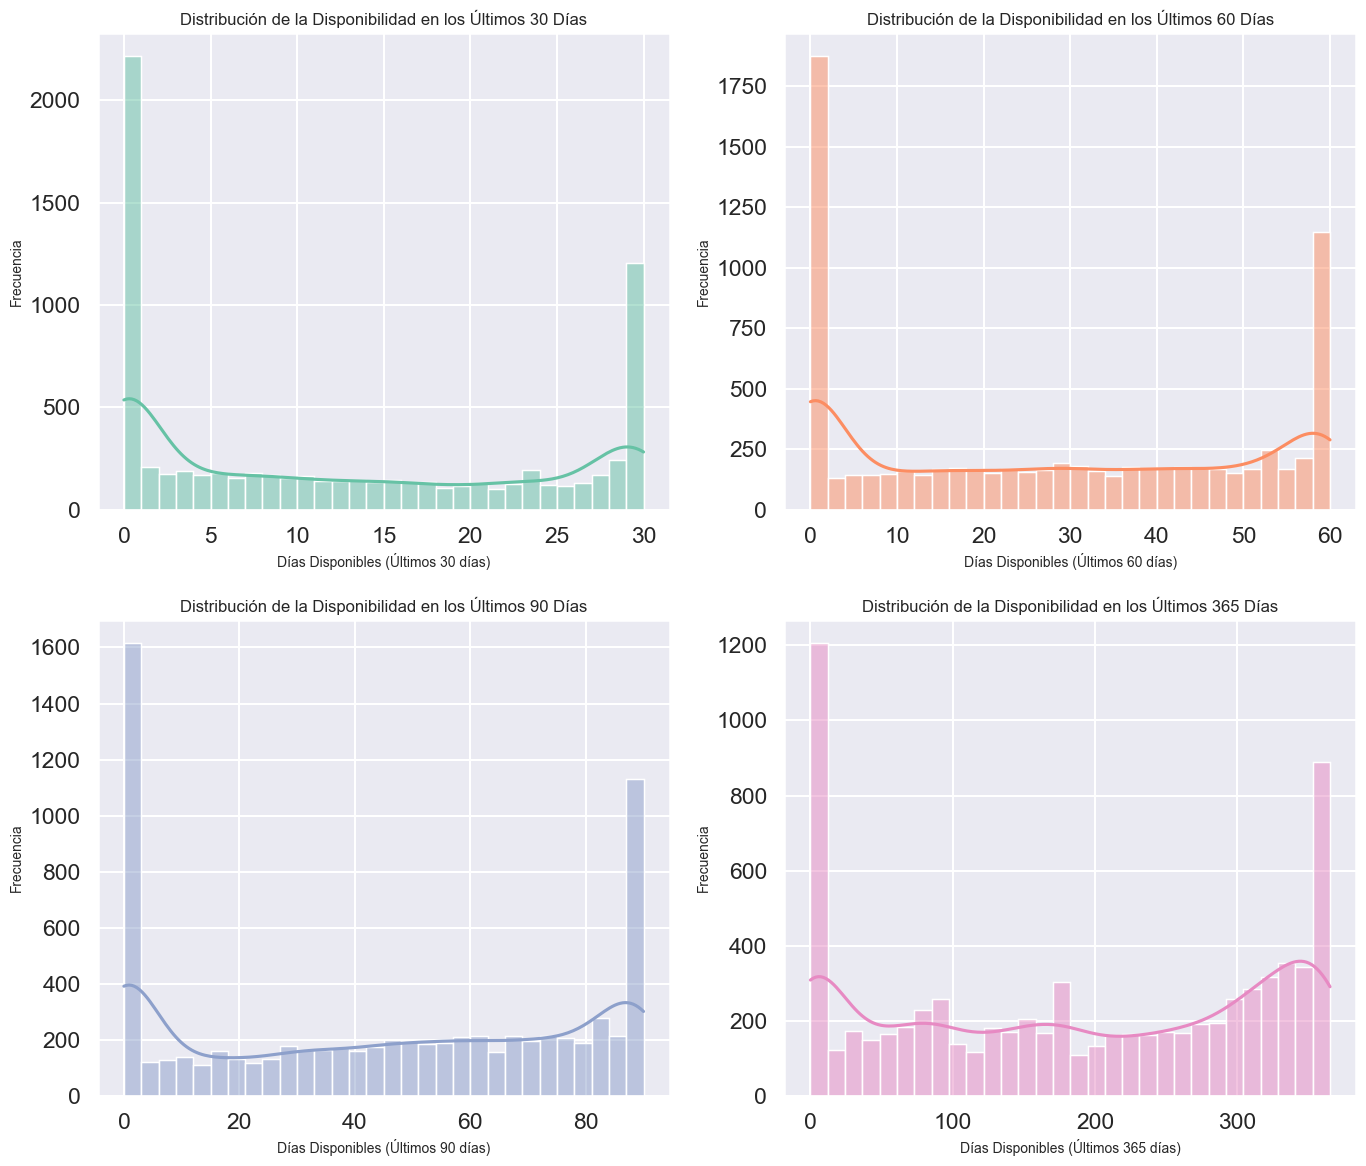

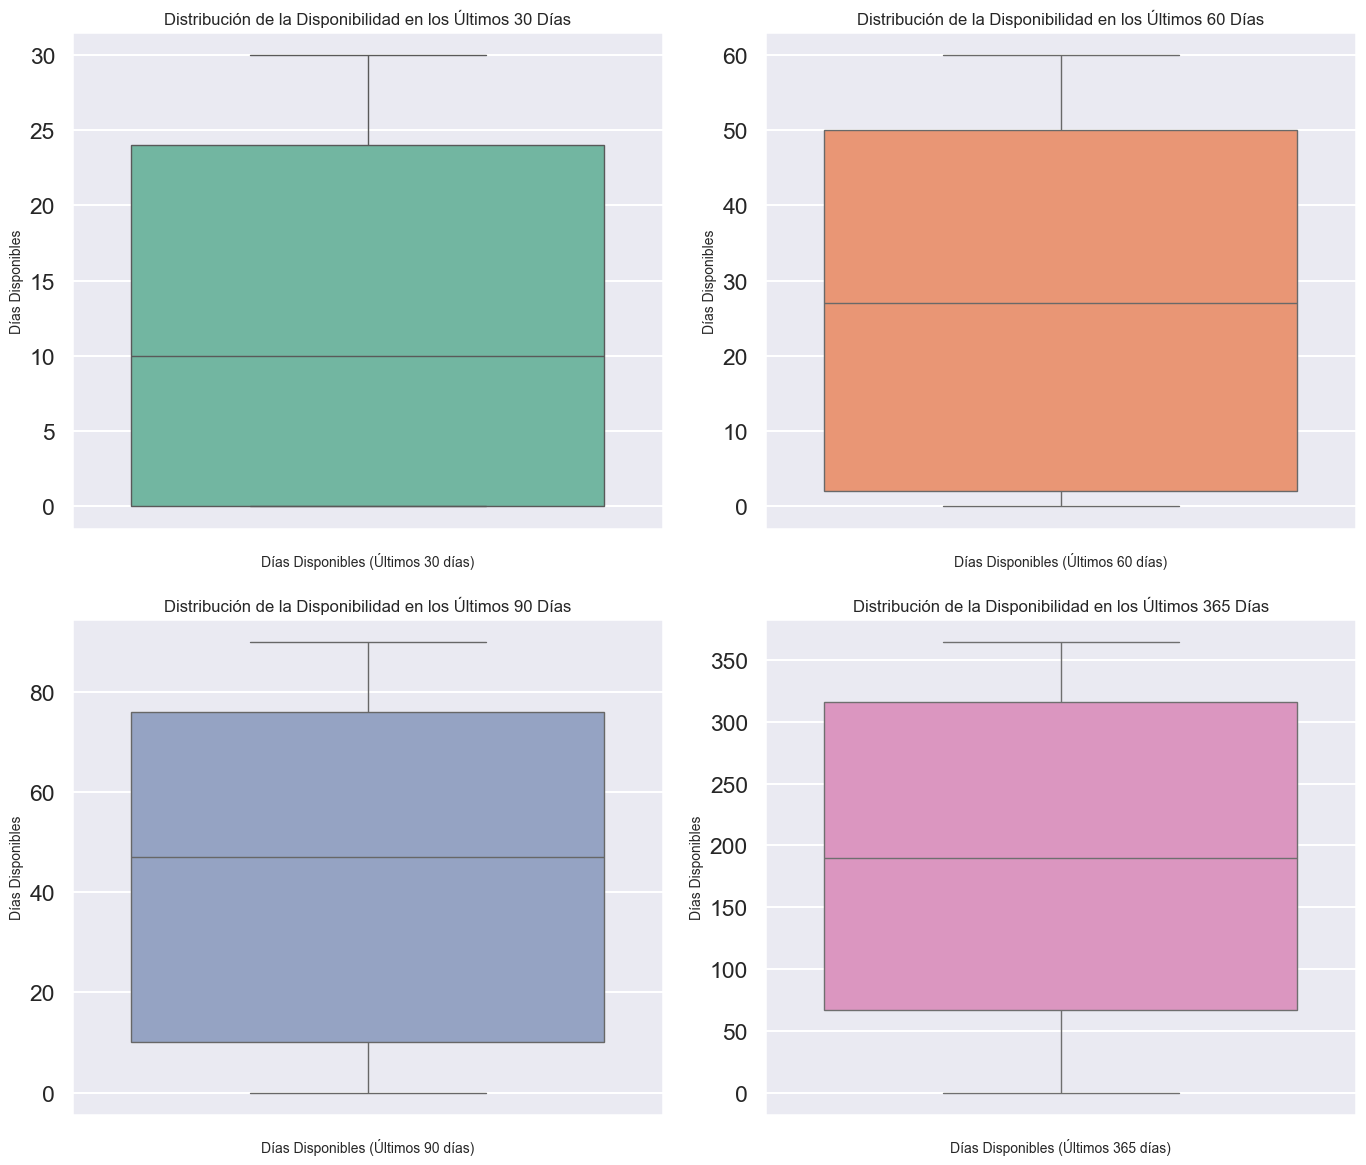

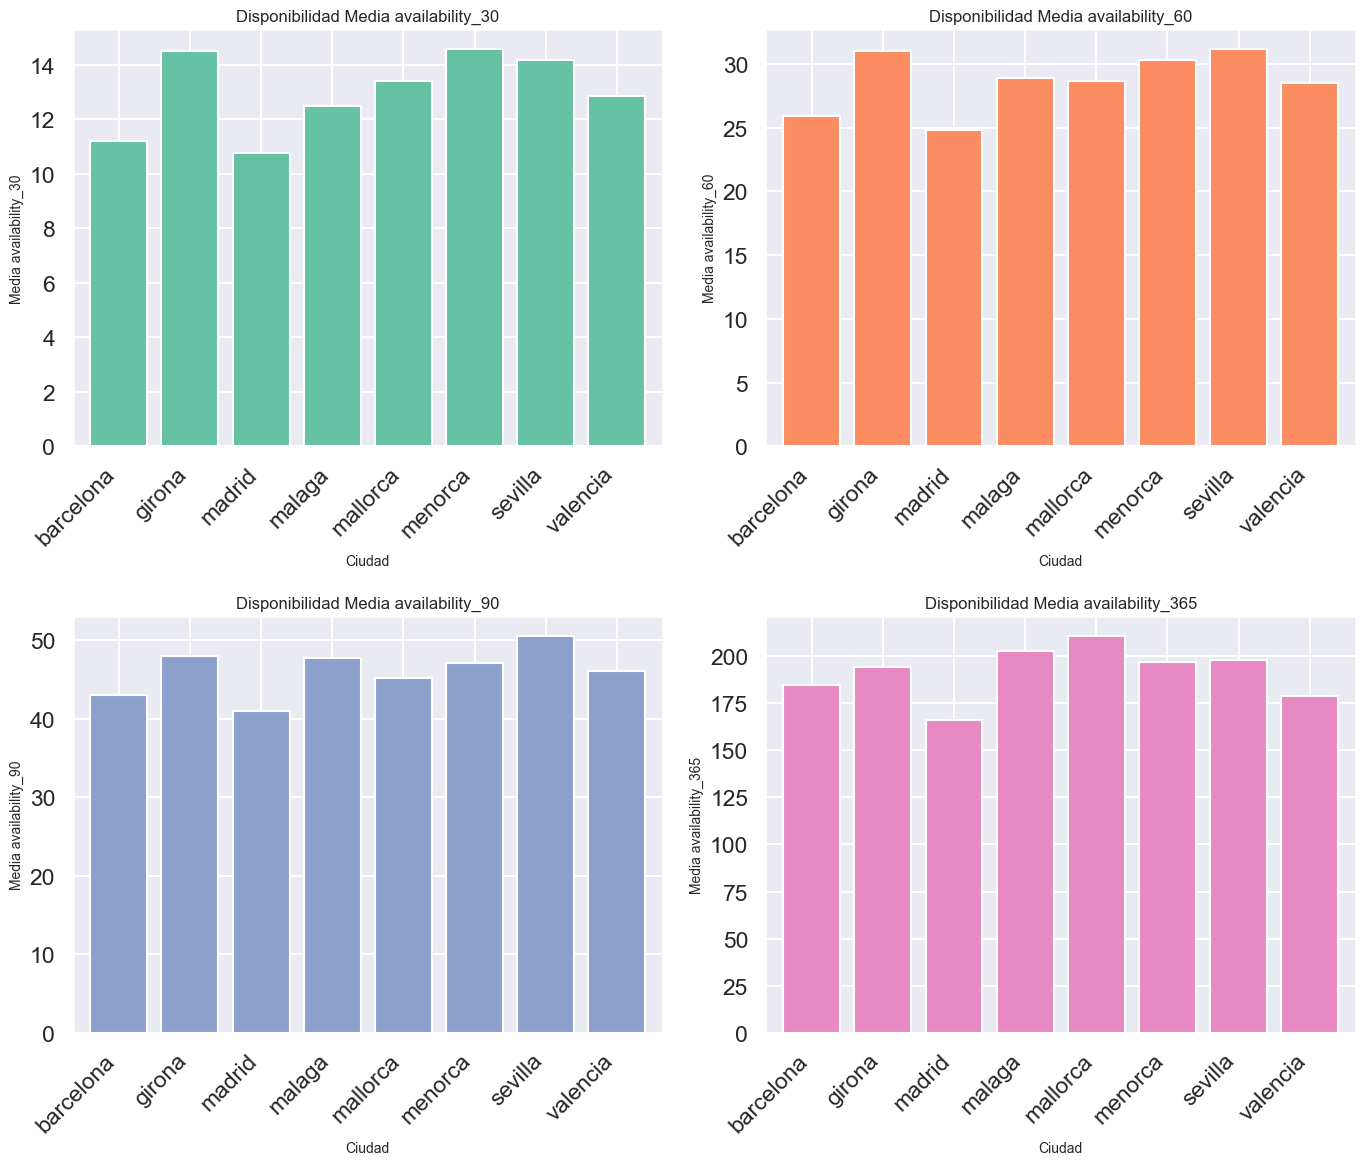

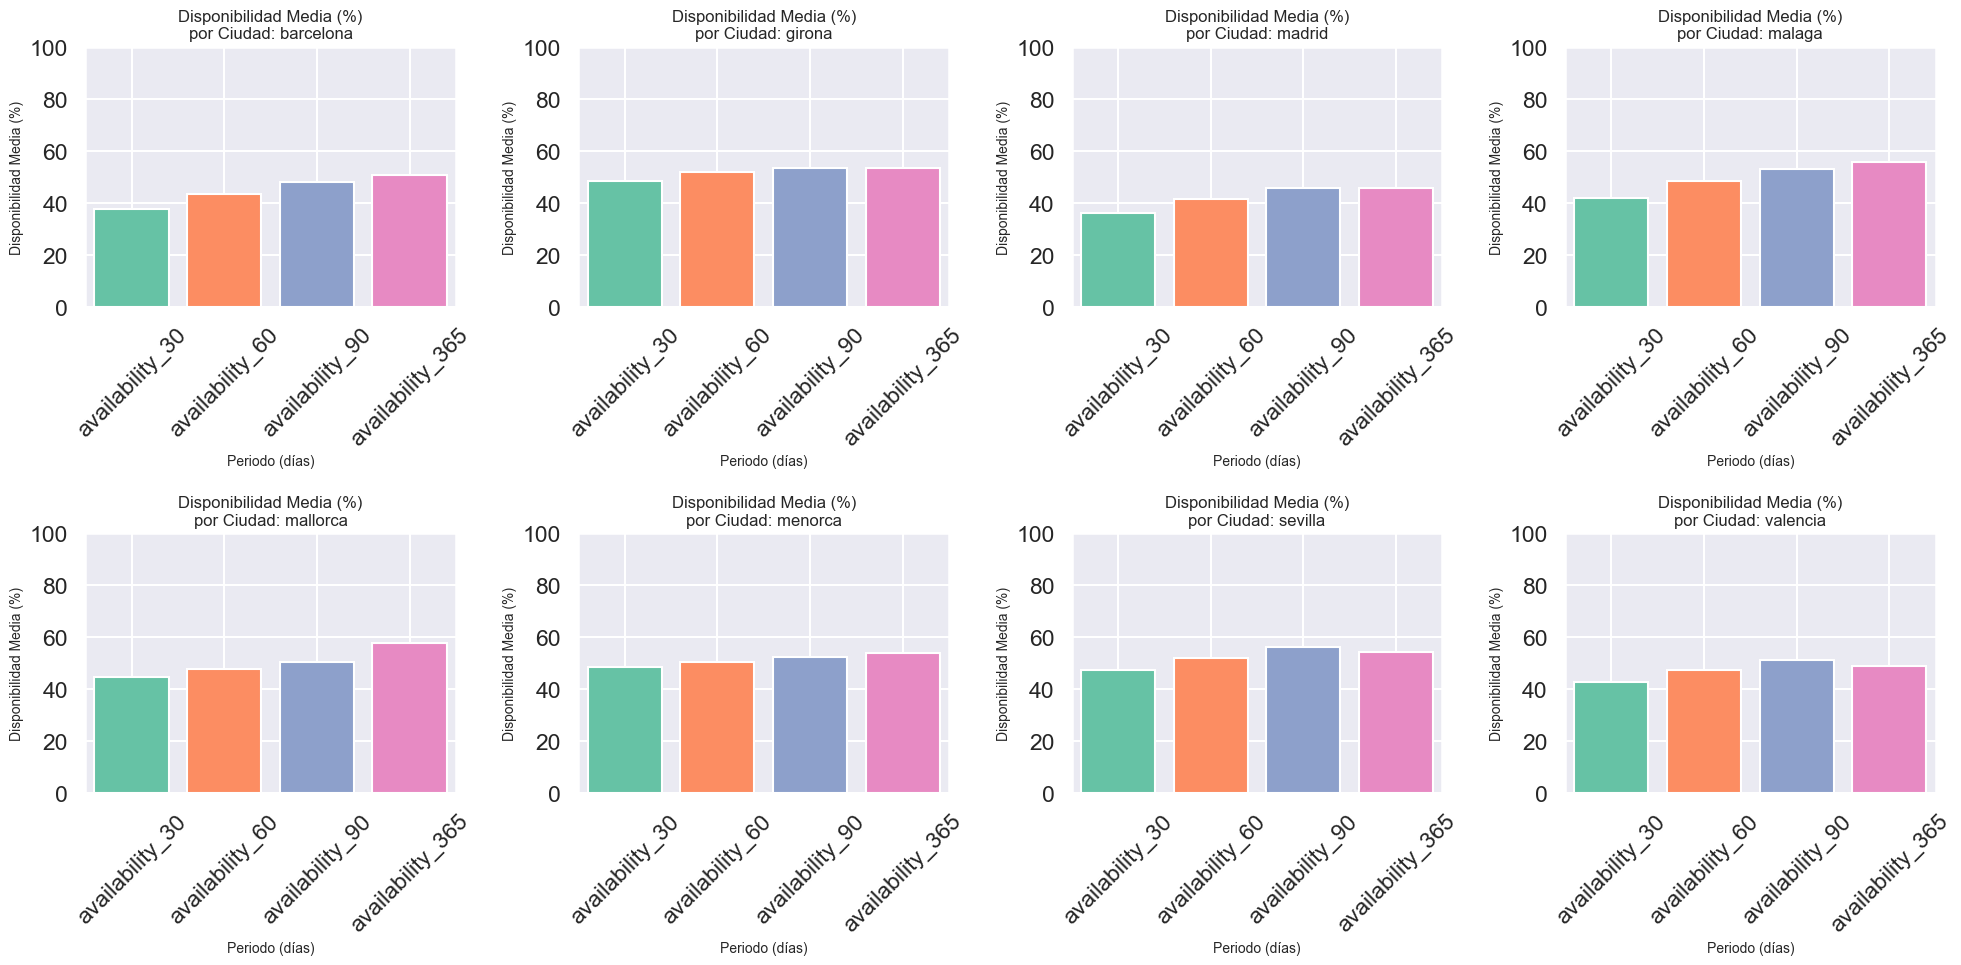

<Figure size 1200x800 with 0 Axes>

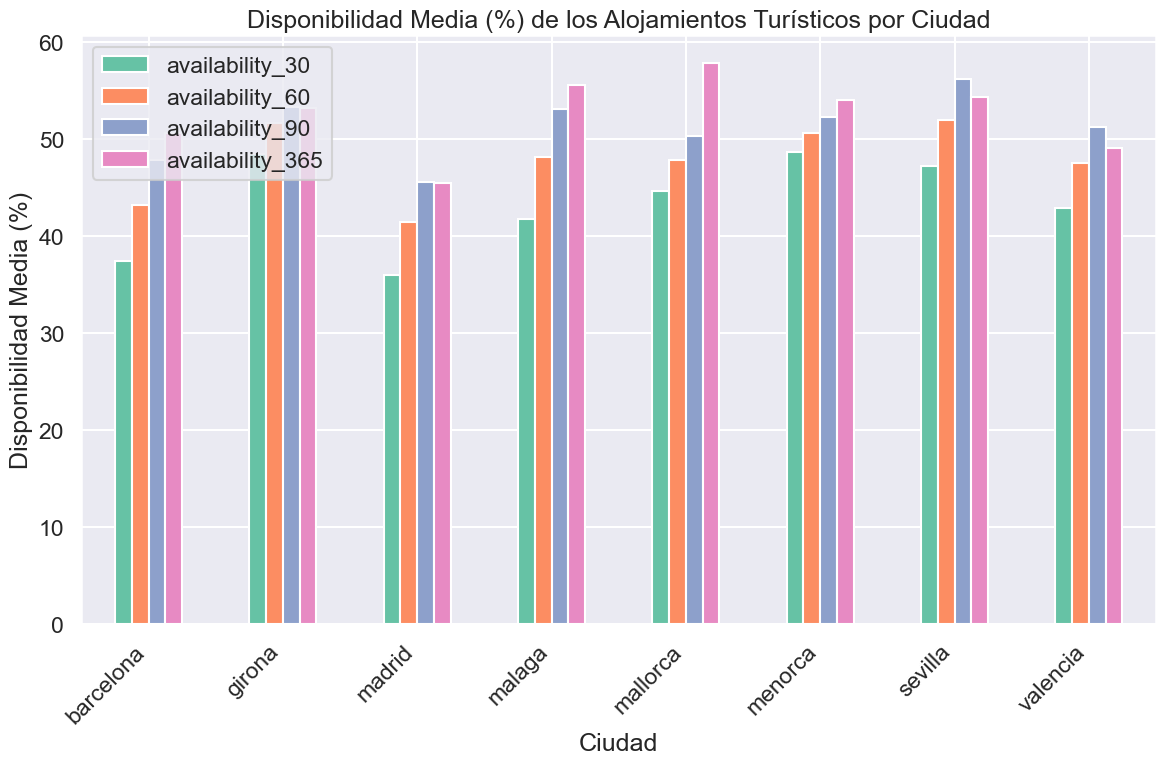

In [335]:
# Primero, calcular los porcentajes y la media
disponibilidad_media = df.groupby('city')[['availability_30', 'availability_60', 'availability_90', 'availability_365']].mean()
disponibilidad_media_porcentaje = disponibilidad_media.copy()

# Calcular los porcentajes para cada columna
disponibilidad_media_porcentaje['availability_30'] = (disponibilidad_media['availability_30'] / 30) * 100
disponibilidad_media_porcentaje['availability_60'] = (disponibilidad_media['availability_60'] / 60) * 100
disponibilidad_media_porcentaje['availability_90'] = (disponibilidad_media['availability_90'] / 90) * 100
disponibilidad_media_porcentaje['availability_365'] = (disponibilidad_media['availability_365'] / 365) * 100

# Definir la paleta de colores
colores = sns.color_palette("Set2", 4)

# Llamar las funciones para generar los gráficos
distribucion_disponibilidadbarras(df, colores)
distribucion_disponibilidadboxplot(df, colores)
mini_graficos_categoria(disponibilidad_media, colores)
graficos_por_ciudad(disponibilidad_media_porcentaje, colores)
grafico_media_todas_las_ciudades(disponibilidad_media_porcentaje, colores)

### EDA Clientes

#### Analisis descriptivo

In [336]:
df[['apartment_id', 'first_review_date', 'last_review_date',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month','city']].describe(include='all')

,apartment_id,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,city
count,7.676000e+03,6112,6111,6033.000000,6024.000000,6030.000000,6019.000000,6028.000000,6018.000000,6018.000000,6112.000000,7676
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,barcelona
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2254
mean,1.698858e+07,2017-02-03 13:39:11.308900352,2018-11-14 16:03:32.076582912,919.640312,94.555113,93.135987,96.288420,96.358660,95.287471,91.417414,125.327880,NaN
min,1.196400e+04,2010-01-02 00:00:00,2012-11-17 00:00:00,200.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,1.000000,NaN
25%,1.078457e+07,2016-03-29 00:00:00,2018-04-09 00:00:00,890.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,18.000000,NaN
50%,1.811248e+07,2017-05-26 00:00:00,2018-12-03 00:00:00,940.000000,100.000000,100.000000,100.000000,100.000000,100.000000,90.000000,58.000000,NaN
75%,2.365679e+07,2018-05-12 00:00:00,2019-09-12 12:00:00,980.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,181.000000,NaN
max,3.242329e+07,2020-10-24 00:00:00,2021-02-13 00:00:00,1000.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1291.000000,NaN


##### Cantidad de apartamentos sin reseñas

In [337]:
sin_reseñas = df['first_review_date'].isna().sum()
print(f"Número de apartamentos sin reseñas: {sin_reseñas}")

Número de apartamentos sin reseñas: 1564


##### Porcentaje de apartamentos del total


In [338]:
porcentaje_sin_reseñas = (sin_reseñas / len(df)) * 100
print(f"Porcentaje de apartamentos sin reseñas: {porcentaje_sin_reseñas:.2f} %")

Porcentaje de apartamentos sin reseñas: 20.38 %


In [339]:
top_apartamentos_puntos = df.sort_values(['review_scores_rating', 'number_of_reviews'], ascending=False)
top_apartamentos_puntos.head(10)

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date,amenities_normalized
2218,11989301,Vivienda San Mart�n II,Rel�jate y desconecta mientras la c�lida luz v...,34840363,SANT FRANCESC,CIUTAT VELLA,Entire home/apt,4,1,1,...,100.0,100.0,100.0,100.0,VERDADERO,394.0,spain,valencia,2019-12-31,"24-hour check-in, air conditioning, baby essen..."
1783,9122183,Casa sevillana en barrio historico,Habitaci�n luminosa con terraza privada para u...,47528412,Pio XII,Macarena,Private room,2,2,1,...,100.0,100.0,90.0,100.0,FALSO,347.0,spain,sevilla,2019-07-29,"24-hour check-in, air conditioning, bathroom e..."
5759,22979863,"Stylish Apt PZA MAYOR/La Latina 2BD* 2BT*, 6p max","Cozy and well-designed 2 bedroom apartment, co...",29281033,Palacio,Centro,Entire home/apt,6,2,2,...,100.0,100.0,100.0,100.0,VERDADERO,376.0,spain,madrid,2021-01-12,"24-hour check-in, air conditioning, baby essen..."
6072,23782265,Romantic and Rustic Penthouse with a Sun Kisse...,Marvel at an adorable cottage-like space in an...,40929334,ARRANCAPINS,EXTRAMURS,Entire home/apt,2,1,1,...,100.0,100.0,100.0,90.0,VERDADERO,501.0,spain,valencia,2020-05-31,"air conditioning, balcony, bathroom essentials..."
5587,22479174,Private room in detached house,"Cozy private room in a detached villa, near Ad...",80975261,Rejas,San Blas - Canillejas,Private room,2,2,1,...,100.0,100.0,100.0,100.0,FALSO,327.0,spain,madrid,2020-08-25,"24-hour check-in, air conditioning, balcony, b..."
3365,16292600,BCN Luxury,Lujoso apartamento en pleno centro de Barcelon...,15944590,l'Antiga Esquerra de l'Eixample,Eixample,Entire home/apt,4,2,2,...,100.0,100.0,100.0,100.0,FALSO,274.0,spain,barcelona,2020-02-16,"24-hour check-in, air conditioning, baby essen..."
309,1073748,"MAGIC PLACE IN BARCELONA, WITH POOL",<b>The space</b><br />MAGIC PLACE IN BARCELONA...,5159312,"Vallvidrera, el Tibidabo i les Planes",Sarri�-Sant Gervasi,Entire home/apt,4,1,1,...,100.0,100.0,100.0,100.0,VERDADERO,101.0,spain,barcelona,2020-11-06,"air conditioning, baby essentials, balcony, ba..."
3717,17384311,"Cubic House Garden, Cala Morlanda.",Cozy designer apartment located in a nice gar...,11087082,Manacor,None,Entire home/apt,3,1,1,...,100.0,100.0,90.0,100.0,VERDADERO,196.0,spain,mallorca,2020-10-21,"24-hour check-in, air conditioning, baby essen..."
5404,21916433,Typical majorcan house in Llucmajor,Cozy 2 floors family house with 5 double bedro...,159911693,Llucmajor,None,Entire home/apt,10,3,5,...,100.0,100.0,90.0,100.0,FALSO,314.0,spain,mallorca,2020-03-22,"air conditioning, balcony, bathroom essentials..."
5408,21925668,�tico con piscina Triana 2mm del Centro de sev...,Nous sommes � Triana � 2mm du centre de Sevill...,15589434,Triana Casco Antiguo,Triana,Entire home/apt,7,2,3,...,100.0,100.0,100.0,100.0,VERDADERO,514.0,spain,sevilla,2019-02-18,"24-hour check-in, air conditioning, baby essen..."


In [340]:
top_apartamentos_num_reviews = df.sort_values(['number_of_reviews', 'review_scores_rating'], ascending=False)
top_apartamentos_num_reviews.head(10)

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date,amenities_normalized
63,384727,Private Room in Center of Seville,"located in the centre of Seville, offers accom...",1920069,Arenal,Casco Antiguo,Private room,2,1,1,...,100.0,100.0,100.0,100.0,FALSO,681.0,spain,sevilla,2019-06-29,"24-hour check-in, air conditioning, bathroom e..."
264,959840,PL REAL (Sq) PENTHOUSE Rooftop,"Rustic penthous with old beams,old ceramic flo...",5223863,el Barri G�tic,Ciutat Vella,Private room,2,2,1,...,100.0,100.0,100.0,100.0,VERDADERO,71.0,spain,barcelona,2019-12-10,"24-hour check-in, air conditioning, balcony, b..."
511,1871218,�tico apartamento VFT/SE/00804,"�tico muy luminoso. Consta de: Sal�n, Ba�o, Co...",9751847,"Le�n XIII, Los Naranjos",Macarena,Entire home/apt,2,1,1,...,100.0,100.0,90.0,80.0,VERDADERO,698.0,spain,sevilla,2020-01-30,"air conditioning, balcony, bathroom essentials..."
729,3058631,"Private Studio in Sol, Madrid","We are offering a clean, well presented and re...",14370747,Sol,Centro,Entire home/apt,3,1,1,...,100.0,100.0,100.0,90.0,FALSO,698.0,spain,madrid,2020-07-17,"24-hour check-in, air conditioning, bathroom e..."
98,526513,Sol. Your home in Madrid�s Heart,DESIGN apartment in the HEART of Madrid.<br />...,1134989,Sol,Centro,Entire home/apt,5,1,2,...,100.0,100.0,100.0,100.0,VERDADERO,491.0,spain,madrid,2021-01-12,"24-hour check-in, air conditioning, baby essen..."
753,3143400,Great room in the center of Madrid,"Bright room in hortaleza Street, next to Gran ...",15328893,Justicia,Centro,Private room,2,1,1,...,100.0,100.0,100.0,100.0,VERDADERO,773.0,spain,madrid,2020-10-17,"air conditioning, balcony, bathroom essentials..."
145,681925,"Very Central, Stunning Views, Sunny Terrace, W...",FANTASTIC PENTHOUSE LOCATED IN THE CENTER OF V...,3462415,EL PILAR,CIUTAT VELLA,Entire home/apt,2,1,1,...,100.0,100.0,100.0,100.0,VERDADERO,624.0,spain,valencia,2019-05-31,"24-hour check-in, air conditioning, balcony, b..."
478,1670427,Walk everywhere!Brand new apartWIFI,The apartment is right in the center of Barce...,8843962,la Dreta de l'Eixample,Eixample,Entire home/apt,5,1,1,...,100.0,100.0,100.0,90.0,VERDADERO,588.0,spain,barcelona,2020-10-12,"air conditioning, baby essentials, bathroom es..."
936,4028518,Renovated & Vintage en Barcelona,Welcome to this cozy apartment located in the ...,20886062,la Sagrada Fam�lia,Eixample,Entire home/apt,4,1,2,...,100.0,100.0,100.0,100.0,VERDADERO,712.0,spain,barcelona,2020-03-16,"24-hour check-in, air conditioning, baby essen..."
1313,6289283,Cozy apartment near El Raval,Nice bright room with large private terrace (p...,32695481,el Raval,Ciutat Vella,Private room,2,1,1,...,100.0,90.0,90.0,90.0,VERDADERO,78.0,spain,barcelona,2020-03-16,"24-hour check-in, air conditioning, balcony, b..."


#### Imputar fecha de inserción del registro para los casos en que hay reseñas y la last_review_date es nula


In [341]:
df.loc[df['last_review_date'].isna() & df['first_review_date'].notna(), 'last_review_date'] = df['insert_date']

#### Graficos

##### Distribución de números de reviews

Text(0.5, 0, 'N.º de reseñas')

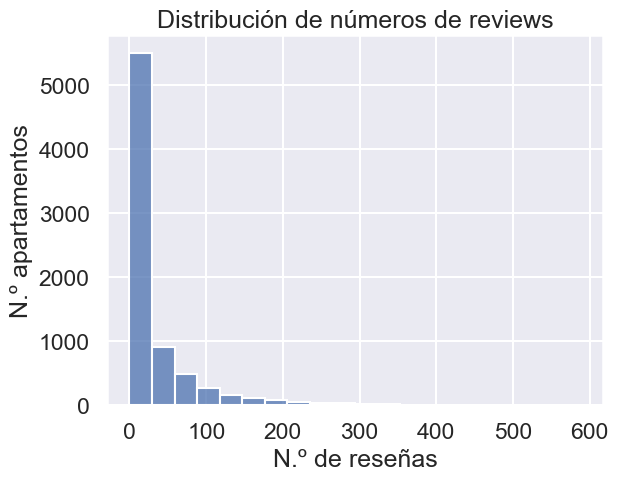

In [342]:
ax = sns.histplot(data=df, x='number_of_reviews', bins=20)
ax.set_title("Distribución de números de reviews")
ax.set_ylabel("N.º apartamentos")
ax.set_xlabel("N.º de reseñas")

##### Kde de distribución de reviews

Text(0.5, 0.98, 'Kde de distribución de reviews')

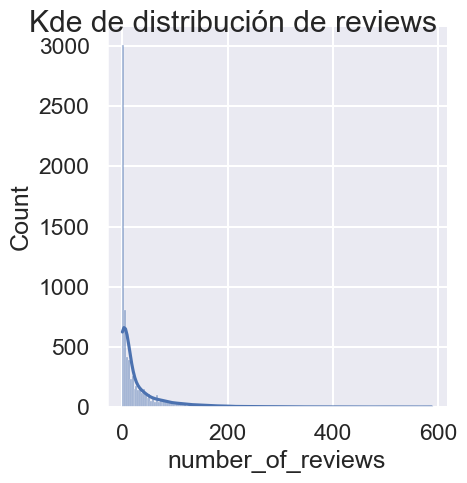

In [343]:
ax = sns.displot(data=df, x='number_of_reviews', kde=True)
ax.figure.suptitle("Kde de distribución de reviews")

##### Distribución estadística del rating total por ciudad

Text(0.5, 1.0, 'Distribución estadística del rating total por ciudad')

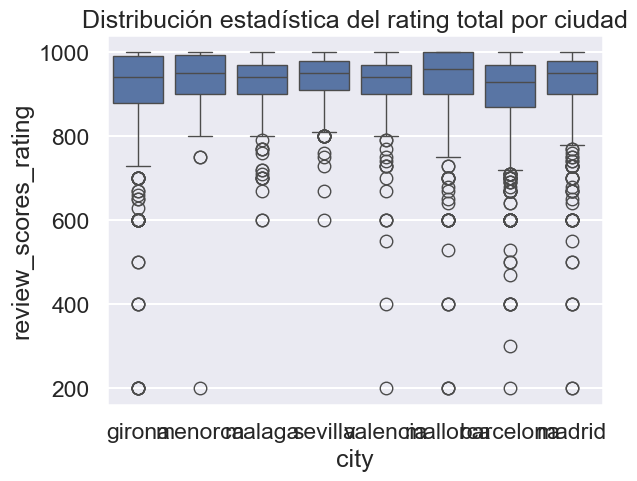

In [344]:
ax = sns.boxplot(data=df, x='city', y='review_scores_rating')
ax.set_title("Distribución estadística del rating total por ciudad")

##### Distribución estadística del rating total por tipo de alojamiento

Text(0.5, 1.0, 'Distribución estadística del rating total por tipo de alojamiento')

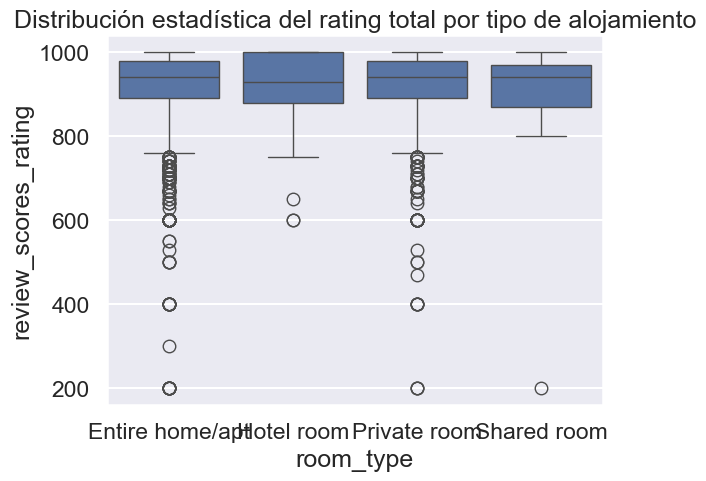

In [345]:
ax = sns.boxplot(data=df, x='room_type', y='review_scores_rating')
ax.set_title("Distribución estadística del rating total por tipo de alojamiento")

#### Frecuencia de reseñas al mes por puntuación

<Axes: xlabel='review_scores_value', ylabel='reviews_per_month'>

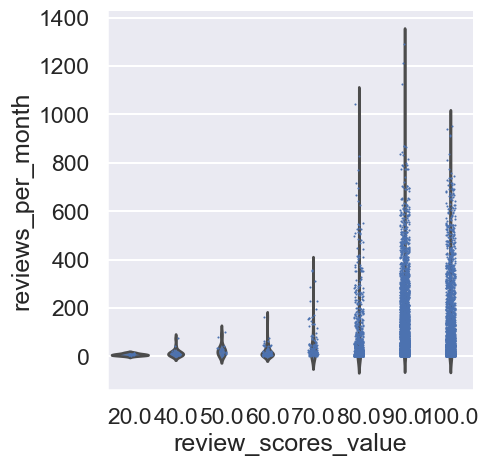

In [346]:
g = sns.catplot(data=df, x='review_scores_value', y='reviews_per_month', kind="violin", inner=None)
sns.stripplot(data=df, x='review_scores_value', y='reviews_per_month', color="b", size=1.5, ax=g.ax)

### EDA Marketing y comunicacion

#### Funciones


##### Función para añadir el símbolo € a los valores del eje

In [347]:
def euro_formatter(x, pos):
    return f"{x:,.0f}€"  # Format amb 0 

##### Función para formatear el eje y con separador de miles

In [348]:
def formato_miles(x, pos):
    return f'{int(x):,}'

##### Establecer paleta y estilo

In [349]:
sns.set_style("darkgrid")
sns.set_palette("tab10") 

#### Analisis Descriptivo

##### Variables numericas

In [350]:
print(df.describe()) 

       apartment_id       host_id  accommodates         beds        price  \
count  7.676000e+03  7.676000e+03   7676.000000  7668.000000  7676.000000   
mean   1.698858e+07  7.107339e+07      4.322303     2.970918  1023.930628   
min    1.196400e+04  1.070400e+04      1.000000     0.000000    60.000000   
25%    1.078457e+07  1.203327e+07      2.000000     1.000000   460.000000   
50%    1.811248e+07  4.890168e+07      4.000000     2.000000   750.000000   
75%    2.365679e+07  1.188815e+08      6.000000     4.000000  1250.000000   
max    3.242329e+07  3.365242e+08     29.000000    30.000000  6071.000000   
std    8.742635e+06  6.572182e+07      2.595476     2.294040   856.822776   

       minimum_nights  maximum_nights  availability_30  availability_60  \
count     7676.000000     7676.000000      7676.000000       7676.00000   
mean         4.581553      760.041688        12.366337         27.58012   
min          1.000000        1.000000         0.000000          0.00000   
25%   

##### Tipos de datos y variables nulas

In [351]:
print(df.info()) 

<class 'pandas.core.frame.DataFrame'>
Index: 7676 entries, 3656 to 3006
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   apartment_id                 7676 non-null   int64         
 1   name                         7673 non-null   object        
 2   description                  7624 non-null   object        
 3   host_id                      7676 non-null   int64         
 4   neighbourhood_name           7676 non-null   object        
 5   neighbourhood_district       4658 non-null   object        
 6   room_type                    7676 non-null   object        
 7   accommodates                 7676 non-null   int64         
 8   bathrooms                    7639 non-null   object        
 9   bedrooms                     7640 non-null   object        
 10  beds                         7668 non-null   float64       
 11  amenities_list               7676 non-null   

#### Distribucion de precios

##### General

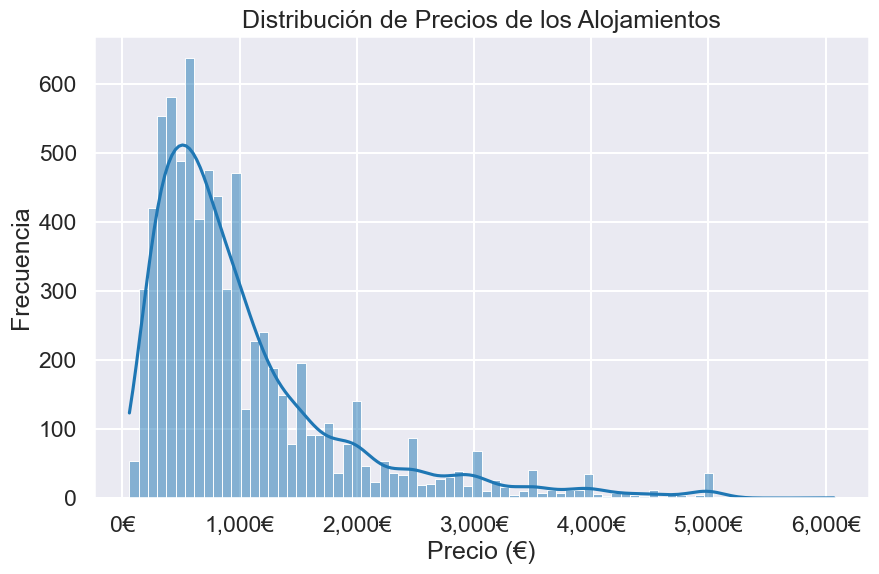

In [352]:
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True) #, color='blue')
plt.title('Distribución de Precios de los Alojamientos')
plt.xlabel('Precio (€)')
plt.ylabel('Frecuencia')
# Aplicar el formatter al eje X para mostrar el símbolo €
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(euro_formatter))
plt.show()

##### Precios por ciudad

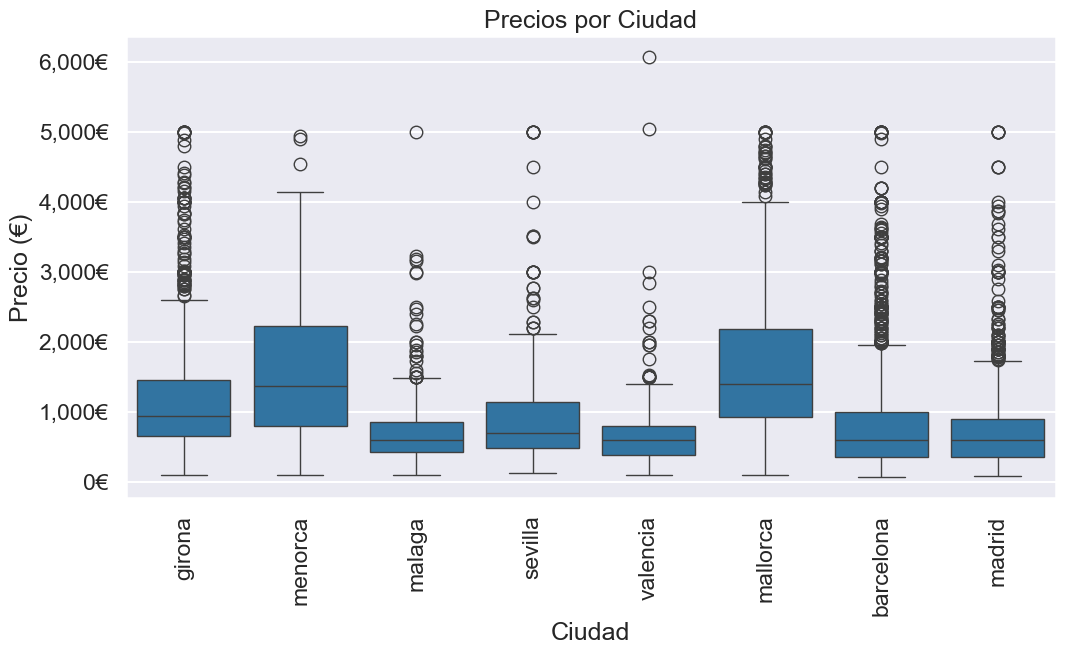

In [353]:
# Boxplot de precios por ciudad
plt.figure(figsize=(12, 6))
sns.boxplot(x='city', y='price', data=df)
plt.title('Precios por Ciudad')
plt.xlabel('Ciudad')
plt.ylabel('Precio (€)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(euro_formatter))
plt.xticks(rotation=90)
plt.show()

##### Precios por tipo de alojamiento

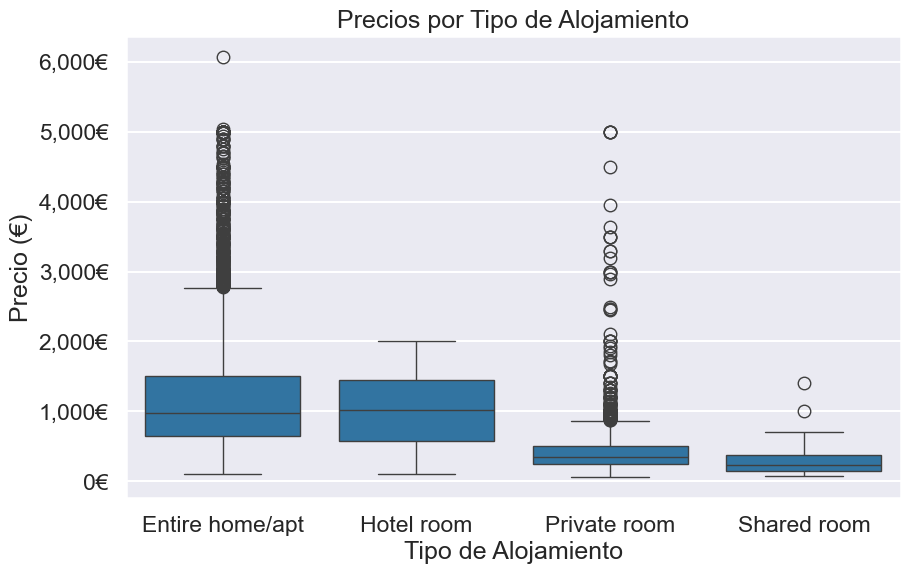

In [354]:
# Boxplot de precios por tipo de alojamiento
plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='price', data=df)
plt.title('Precios por Tipo de Alojamiento')
plt.xlabel('Tipo de Alojamiento')
plt.ylabel('Precio (€)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(euro_formatter))
plt.show()

##### Precios por numeros de cama

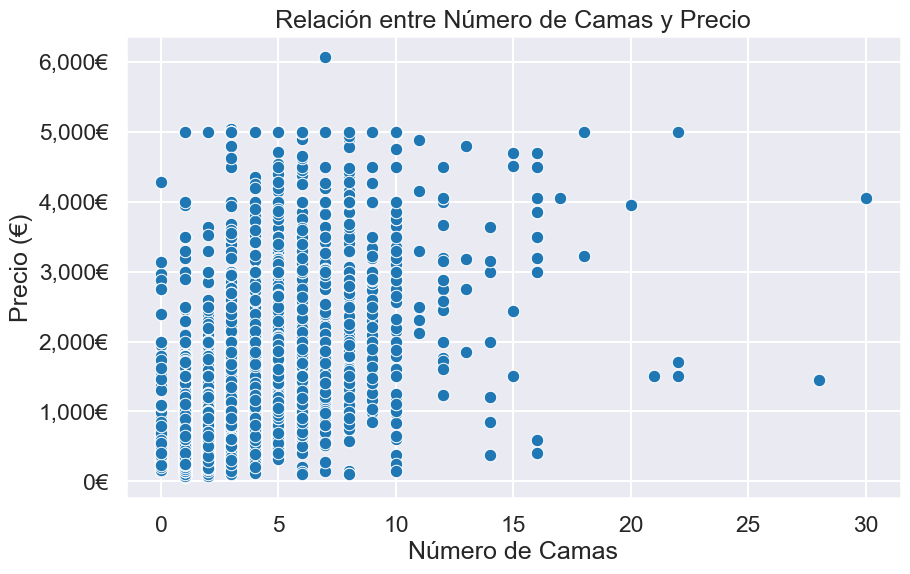

In [355]:
# Relación entre el número de camas y el precio
plt.figure(figsize=(10, 6))
sns.scatterplot(x='beds', y='price', data=df)
plt.title('Relación entre Número de Camas y Precio')
plt.xlabel('Número de Camas')
plt.ylabel('Precio (€)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(euro_formatter))
plt.show()

##### Precios por numero de habitaciones

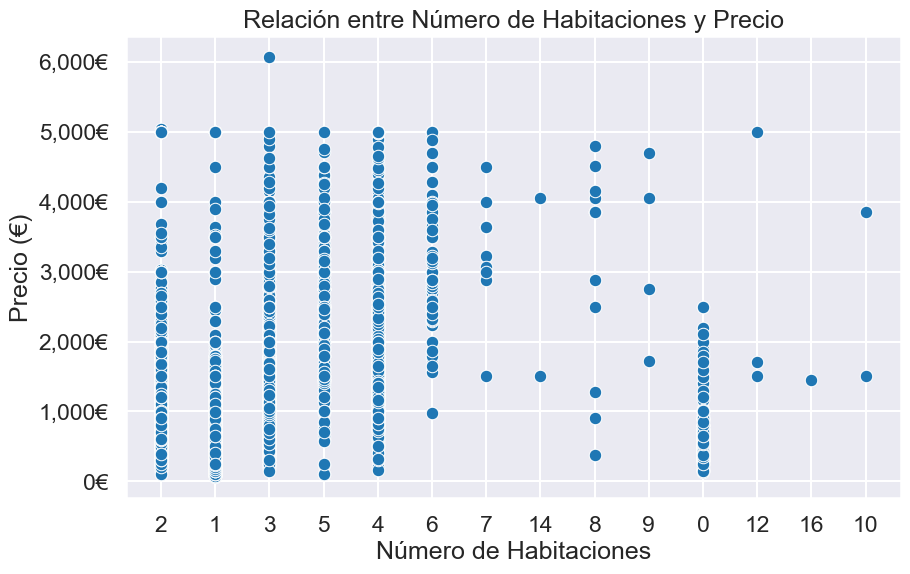

In [356]:
# Relación entre el número de habitaciones y el precio
plt.figure(figsize=(10, 6))
sns.scatterplot(x='bedrooms', y='price', data=df)
plt.title('Relación entre Número de Habitaciones y Precio')
plt.xlabel('Número de Habitaciones')
plt.ylabel('Precio (€)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(euro_formatter))
plt.show()

#### Reserva instantanea y Distribucion

##### Porcentaje de alojamiento con reserva instantanea

In [357]:
instant_bookable_percentage = df['is_instant_bookable'].value_counts(normalize=True) * 100
print(instant_bookable_percentage)

is_instant_bookable
VERDADERO    55.406462
FALSO        44.593538
Name: proportion, dtype: float64


##### Distribución de alojamientos con reserva instantánea

/var/folders/zd/c44thsy53rq3c4k8x7lqbfdh0000gn/T/ipykernel_1790/1596701451.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




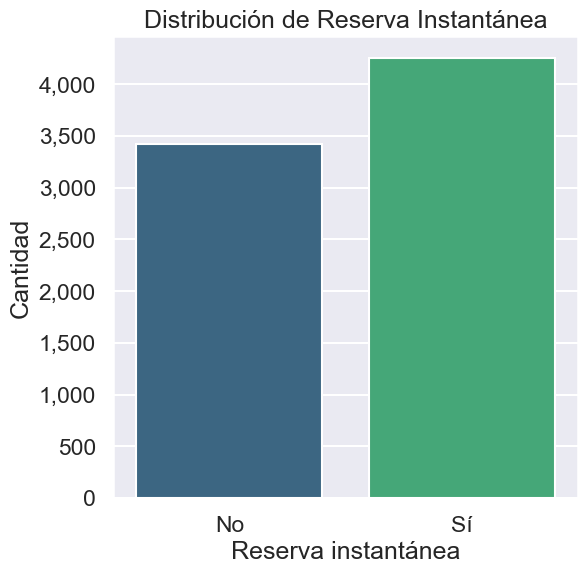

In [358]:
plt.figure(figsize=(6, 6))
sns.countplot(x='is_instant_bookable', data=df, palette='viridis')

plt.gca().yaxis.set_major_formatter(FuncFormatter(formato_miles))

plt.xlabel('Reserva instantánea')
plt.ylabel('Cantidad')
plt.title('Distribución de Reserva Instantánea')
plt.xticks([0, 1], ['No', 'Sí'])
plt.show()

#### Analisis de reseñas

##### Numero de reseñas y puntuaciones

Reseñas

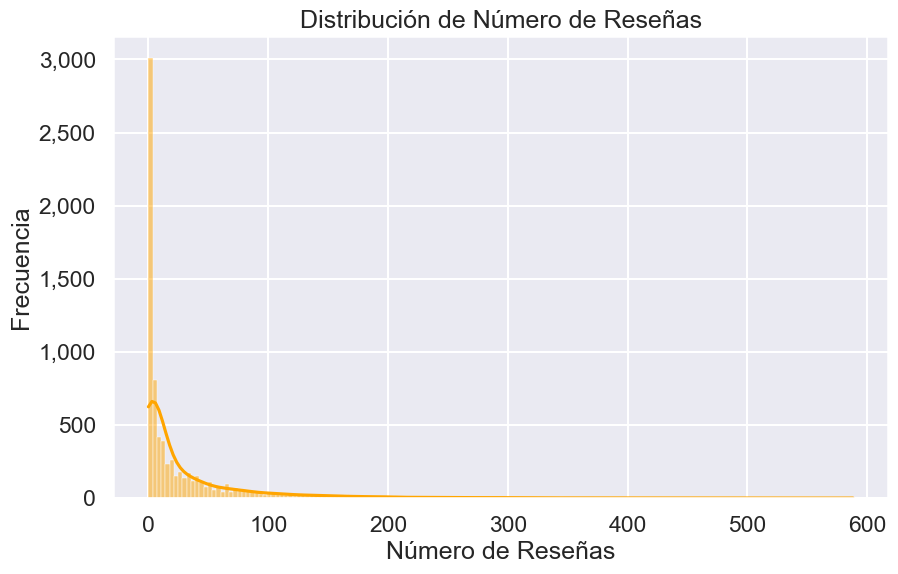

In [359]:
# Histograma de número de reseñas
plt.figure(figsize=(10, 6))
sns.histplot(df['number_of_reviews'], kde=True, color='orange')

plt.gca().yaxis.set_major_formatter(FuncFormatter(formato_miles))

plt.title('Distribución de Número de Reseñas')
plt.xlabel('Número de Reseñas')
plt.ylabel('Frecuencia')
plt.show()

Puntuaciones

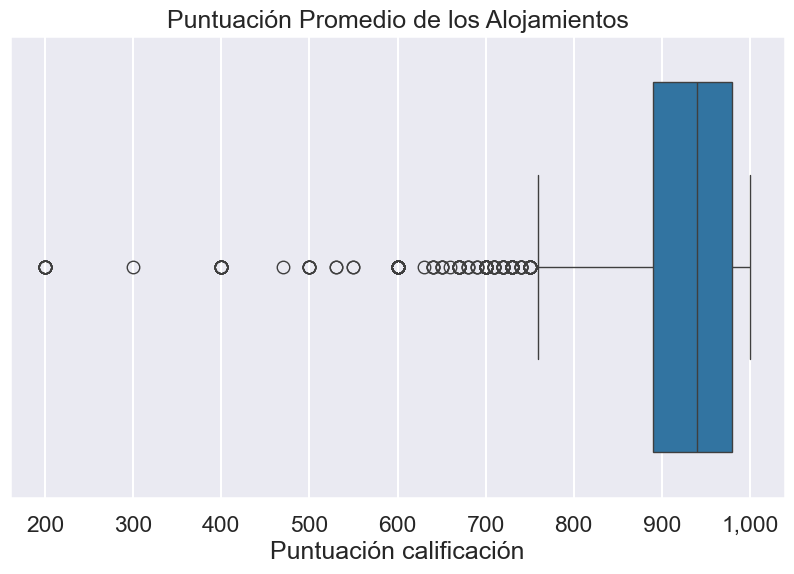

In [360]:
 # Boxplot de puntuaciones
plt.figure(figsize=(10, 6))
sns.boxplot(x='review_scores_rating', data=df)

plt.gca().xaxis.set_major_formatter(FuncFormatter(formato_miles))

plt.xlabel('Puntuación calificación')
plt.title('Puntuación Promedio de los Alojamientos')
plt.show()

##### Puntuaciones por tipo de alojamiento

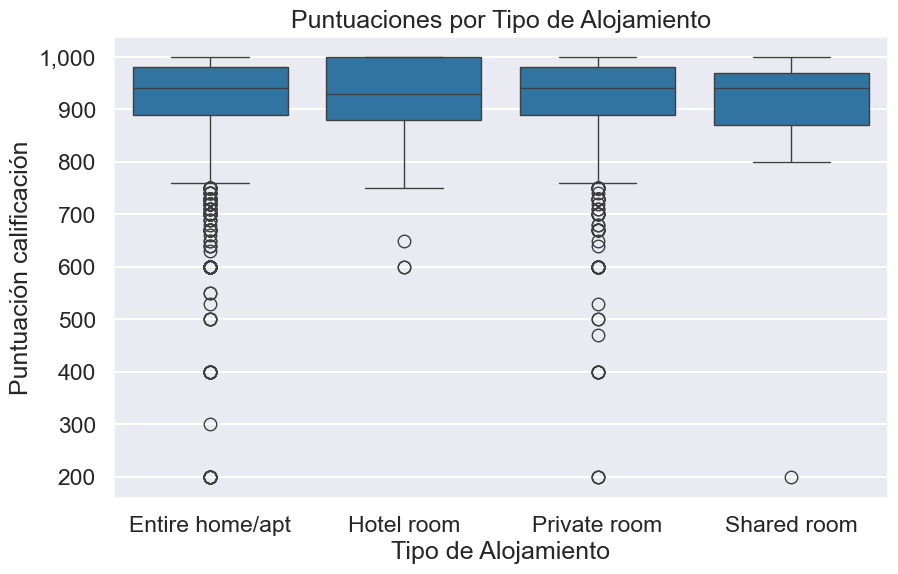

In [361]:
# Boxplot de puntuaciones por tipo de alojamiento
plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='review_scores_rating', data=df)

plt.gca().yaxis.set_major_formatter(FuncFormatter(formato_miles))

plt.xlabel('Tipo de Alojamiento')
plt.ylabel('Puntuación calificación')
plt.title('Puntuaciones por Tipo de Alojamiento')
plt.show()

# KPIs

## KPI 1 - Tasa de ocupación mensual

### Tasa de ocupacion mensual general

In [362]:
# Suponiendo que 'availability_30' es el número de días disponibles en los últimos 30 días

# Calcular el número de días ocupados
df['days_occupied'] = 30 - df['availability_30']  # Si 'availability_30' tiene los días disponibles, restamos a 30

# Calcular la tasa de ocupación mensual
df['occupancy_rate'] = (df['days_occupied'] / 30) * 100  # Tasa de ocupación en porcentaje

# Mostrar las primeras filas con el KPI calculado
df[['apartment_id', 'city', 'room_type', 'availability_30', 'days_occupied', 'occupancy_rate']]

,apartment_id,city,room_type,availability_30,days_occupied,occupancy_rate
3656,17249166,girona,Entire home/apt,0,30,100.000000
5770,23040910,menorca,Entire home/apt,29,1,3.333333
7894,31968299,girona,Entire home/apt,0,30,100.000000
6749,26207763,girona,Entire home/apt,0,30,100.000000
4507,19236052,girona,Entire home/apt,0,30,100.000000
...,...,...,...,...,...,...
226,888635,barcelona,Entire home/apt,0,30,100.000000
3323,16166606,barcelona,Entire home/apt,0,30,100.000000
3188,15695052,barcelona,Private room,29,1,3.333333
2066,11198148,barcelona,Private room,20,10,33.333333


In [363]:
# Calcular el total de días ocupados y el total de días analizados
total_days_occupied = df['days_occupied'].sum()
total_days_analyzed = len(df) * 30  # 30 días por cada propiedad

# Calcular la tasa de ocupación general
general_occupancy_rate = (total_days_occupied / total_days_analyzed) * 100

# Mostrar el resultado
print(f"La tasa de ocupación general final es: {general_occupancy_rate:.2f}%")

La tasa de ocupación general final es: 58.78%


In [364]:
# Agrupar por ciudad y tipo de alojamiento y calcular la tasa de ocupación promedio
kpi_occupancy = df.groupby(['city'])['occupancy_rate'].mean().reset_index()

# Formatear el 'occupancy_rate' a porcentaje con 2 decimales
kpi_occupancy['occupancy_rate'] = kpi_occupancy['occupancy_rate'].apply(lambda x: f"{x:.2f}%")

# Mostrar el KPI por ciudad y tipo de alojamiento
print(kpi_occupancy)

        city occupancy_rate
0  barcelona         62.62%
1     girona         51.59%
2     madrid         64.07%
3     malaga         58.32%
4   mallorca         55.35%
5    menorca         51.41%
6    sevilla         52.75%
7   valencia         57.14%


### KPI 1 - Tasa de ocupación por tipo de alojamiento:
    KPI de ocupación promedio por ciudad y tipo de alojamiento.

In [365]:
# Agrupar por ciudad y tipo de alojamiento y calcular la tasa de ocupación promedio
kpi_occupancy = df.groupby(['city', 'room_type'])['occupancy_rate'].mean().reset_index()

# Formatear el 'occupancy_rate' a porcentaje con 2 decimales
kpi_occupancy['occupancy_rate'] = kpi_occupancy['occupancy_rate'].apply(lambda x: f"{x:.2f}%")

# Mostrar el KPI por ciudad y tipo de alojamiento
print(kpi_occupancy)

         city        room_type occupancy_rate
0   barcelona  Entire home/apt         63.68%
1   barcelona       Hotel room         58.89%
2   barcelona     Private room         62.16%
3   barcelona      Shared room         34.39%
4      girona  Entire home/apt         51.63%
5      girona       Hotel room         86.67%
6      girona     Private room         47.62%
7      madrid  Entire home/apt         63.32%
8      madrid       Hotel room         46.67%
9      madrid     Private room         66.42%
10     madrid      Shared room         45.00%
11     malaga  Entire home/apt         58.22%
12     malaga       Hotel room         33.33%
13     malaga     Private room         59.11%
14     malaga      Shared room         76.67%
15   mallorca  Entire home/apt         55.86%
16   mallorca       Hotel room         68.52%
17   mallorca     Private room         48.22%
18   mallorca      Shared room         57.50%
19    menorca  Entire home/apt         51.58%
20    menorca     Private room    

### KPI 1 - Tasa de ocupación agrupada por ciudad y tipo de alojamiento en %

In [366]:
# Agrupar por ciudad y tipo de alojamiento y calcular la tasa de ocupación promedio
kpi_occupancy = df.groupby(['city', 'room_type'])['occupancy_rate'].mean().reset_index()

# Formatear el 'occupancy_rate' a porcentaje con 2 decimales
kpi_occupancy['occupancy_rate'] = kpi_occupancy['occupancy_rate'].apply(lambda x: f"{x:.2f}%")

# Mostrar el KPI por ciudad y tipo de alojamiento
print(kpi_occupancy)

         city        room_type occupancy_rate
0   barcelona  Entire home/apt         63.68%
1   barcelona       Hotel room         58.89%
2   barcelona     Private room         62.16%
3   barcelona      Shared room         34.39%
4      girona  Entire home/apt         51.63%
5      girona       Hotel room         86.67%
6      girona     Private room         47.62%
7      madrid  Entire home/apt         63.32%
8      madrid       Hotel room         46.67%
9      madrid     Private room         66.42%
10     madrid      Shared room         45.00%
11     malaga  Entire home/apt         58.22%
12     malaga       Hotel room         33.33%
13     malaga     Private room         59.11%
14     malaga      Shared room         76.67%
15   mallorca  Entire home/apt         55.86%
16   mallorca       Hotel room         68.52%
17   mallorca     Private room         48.22%
18   mallorca      Shared room         57.50%
19    menorca  Entire home/apt         51.58%
20    menorca     Private room    

### KPI 1 - Matriz Tasa de ocupación por ciudad y tipo de alojamientos en %

In [367]:
# Agrupar por ciudad y tipo de alojamiento y calcular la tasa de ocupación promedio
kpi_occupancy = df.groupby(['city', 'room_type'])['occupancy_rate'].mean().reset_index()

# Formatear el 'occupancy_rate' a porcentaje con 2 decimales
kpi_occupancy['occupancy_rate'] = kpi_occupancy['occupancy_rate'].apply(lambda x: f"{x:.2f}%")

# Convertir el dataframe a una matriz con las ciudades como filas y los tipos de alojamiento como columnas
occupancy_matrix = kpi_occupancy.pivot_table(index='city', columns='room_type', values='occupancy_rate', aggfunc='first')

# Para reemplazar por 0 si NaN
occupancy_matrix = occupancy_matrix.fillna('0.00%')

# Convertir a formato tabla con tabulate para una mejor visualización en rejilla
occupancy_matrix_formatted = tabulate(occupancy_matrix, headers='keys', tablefmt='grid', showindex=True)

# Mostrar la tabla en formato rejilla
print(occupancy_matrix_formatted)

+-----------+-------------------+--------------+----------------+---------------+
| city      | Entire home/apt   | Hotel room   | Private room   | Shared room   |
+===========+===================+==============+================+===============+
| barcelona | 63.68%            | 58.89%       | 62.16%         | 34.39%        |
+-----------+-------------------+--------------+----------------+---------------+
| girona    | 51.63%            | 86.67%       | 47.62%         | 0.00%         |
+-----------+-------------------+--------------+----------------+---------------+
| madrid    | 63.32%            | 46.67%       | 66.42%         | 45.00%        |
+-----------+-------------------+--------------+----------------+---------------+
| malaga    | 58.22%            | 33.33%       | 59.11%         | 76.67%        |
+-----------+-------------------+--------------+----------------+---------------+
| mallorca  | 55.86%            | 68.52%       | 48.22%         | 57.50%        |
+-----------+---

## KPI 2 - Ciudad con mayor ocupación mensual

In [368]:
# La tasa de ocupación mensual ya la tenemos calculada

# Agrupar por ciudad y calcular la tasa de ocupación promedio mensual
occupancy_by_city = df.groupby('city')['occupancy_rate'].mean().reset_index()

# Encontrar la ciudad con mayor tasa de ocupación mensual
max_occupancy_city = occupancy_by_city.loc[occupancy_by_city['occupancy_rate'].idxmax()]

# Mostrar la ciudad con mayor ocupación
print(f"La ciudad con mayor ocupación mensual es {max_occupancy_city['city']} con una tasa de ocupación del {max_occupancy_city['occupancy_rate']:.2f}%")



La ciudad con mayor ocupación mensual es madrid con una tasa de ocupación del 64.07%


## KPI 3 - Índice de satisfacción general

In [369]:
Indice_satisfaccion_general = df['review_scores_value'].sum() / df['apartment_id'].count()

print(f'El índice de satisfacción general es: {Indice_satisfaccion_general:.2f}')

El índice de satisfacción general es: 71.67


In [370]:
fig = go.Figure(go.Indicator(
    mode = "gauge+number+delta",
    value = Indice_satisfaccion_general,
    title = {'text': "Índice de satisfacción general"},
    delta = {'reference': 73.78},
    gauge= {'axis': {'visible': False}}
))

fig.show()

## KPI 4 - Ítem con la mayor puntuación promedio

In [412]:
# Diccionario para traducir los nombres de las columnas de evaluación específicas
traducciones = {
    'review_scores_accuracy': 'Precisión',
    'review_scores_cleanliness': 'Limpieza',
    'review_scores_checkin': 'Entrada',
    'review_scores_communication': 'Comunicación',
    'review_scores_location': 'Ubicación'
}

# Columnas originales
cols = list(traducciones.keys())

# Calcular la media de cada una (ignorando NaN)
mean_scores = df[cols].mean().rename(traducciones)

# Mostrar la métrica con mayor media
max_metric = mean_scores.idxmax()
max_value = mean_scores.max()

print(f"La métrica con la mayor puntuación promedio es: {max_metric} con un valor de {max_value:.2f}")

La métrica con la mayor puntuación promedio es: Comunicación con un valor de 96.36


Gráfica de radar para representar las puntuaciones

In [413]:
#Trazamos la gráfica de radar

fig = px.line_polar(df, r=mean_scores.values, theta=mean_scores.index, range_r=(90, 100), line_close=True)
fig.update_traces(fill='toself')

#Añadimos los valores

fig.add_trace(go.Scatterpolar(
    r=mean_scores.values,
    theta=mean_scores.index,
    mode='markers+text',
    marker=dict(color='blue', size=5, symbol='circle'),
    text=mean_scores.values.round(2),
    textposition='top center',
    name='Valores',
    showlegend=False
))

#Marcamos el valor máximo

fig.add_trace(go.Scatterpolar(
    r=[max_value],
    theta=[max_metric],
    mode='markers',
    marker=dict(color='red', size=10, symbol='circle'),
    name='Valor máximo',
    showlegend=False
))

# Preguntas de negocio Sprint 1

## Operaciones

### Quina és la disponibilitat mitjana dels allotjaments turístics en els diferents terminis (30, 60, 90 i 365 dies) a cada ciutat?

#### Funciones

In [373]:
def grafico_matriz_disponibilidad(disponibilidad_media, disponibilidad_media_porcentaje):
    plt.figure(figsize=(12, 8)) 
    
    matrix_combined = disponibilidad_media_porcentaje.copy()

    annotaciones = disponibilidad_media.T.apply(lambda x: x.map(lambda v: f"{round(v)} días"))
    
    sns.heatmap(matrix_combined.T, annot=annotaciones.values, fmt="", cmap='coolwarm', cbar_kws={'label': 'Disponibilidad Media (%)'}, linewidths=1)
    
    plt.title('Matriz de Disponibilidad Media por Ciudad (Porcentaje en colores, Media Normal en celdas)', fontsize=16)
    plt.xlabel('Ciudad', fontsize=12)
    plt.ylabel('Periodo de Disponibilidad', fontsize=12)
    plt.xticks(rotation=45, ha='right')  
    
    plt.tight_layout()
    plt.show()


In [374]:
def distribucion_disponibilidad_kde(df, colores):
    fig, ax = plt.subplots(2, 2, figsize=(14, 12))

    periodos = ['30', '60', '90', '365']
    disponibilidades = [df['availability_30'], df['availability_60'], df['availability_90'], df['availability_365']]

    for i, (periodo, disponibilidad) in enumerate(zip(periodos, disponibilidades)):
        fila = i // 2
        columna = i % 2
        sns.kdeplot(disponibilidad, fill=True, color=colores[i], ax=ax[fila, columna]) 

        ax[fila, columna].set_title(f'Distribución de la Disponibilidad en los Últimos {periodo} Días', fontsize=12)
        ax[fila, columna].set_xlabel(f'Días Disponibles (Últimos {periodo} días)', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    


#### Matriz de distribucion de disponibilidad

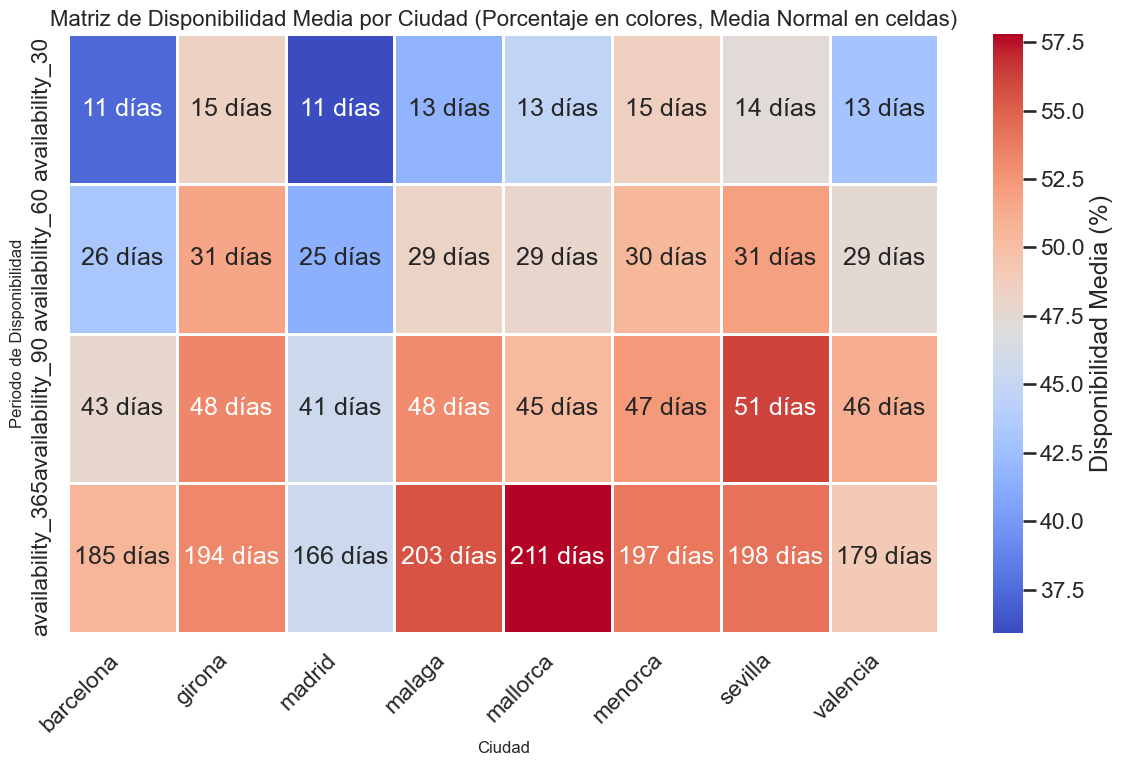

In [375]:
grafico_matriz_disponibilidad(disponibilidad_media, disponibilidad_media_porcentaje)

#### Densidad de distribucion

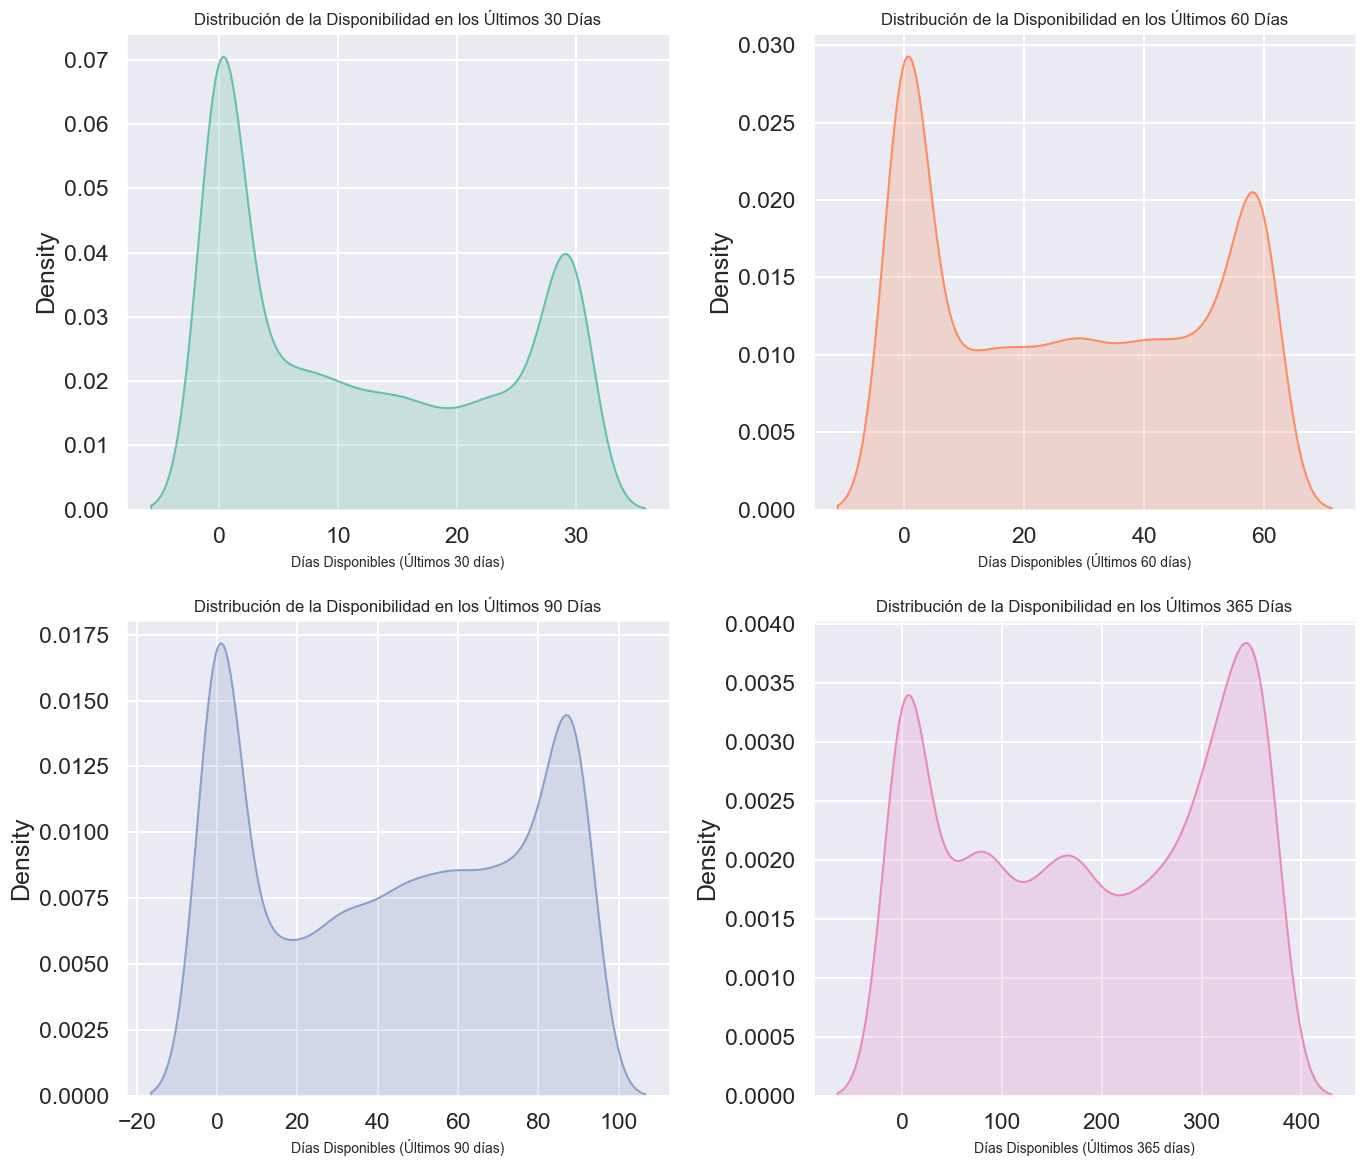

In [376]:
distribucion_disponibilidad_kde(df, colores)

In [377]:
availability_cols = ['availability_30', 'availability_60', 'availability_90', 'availability_365']

# Creamos una pivot table con 'city' como índice, aplicando la función mean para cada columna
availability_matrix = df.pivot_table(
    index='city',
    values=availability_cols,
    aggfunc='mean'
)

print(availability_matrix)

           availability_30  availability_365  availability_60  availability_90
city                                                                          
barcelona        11.212511        184.850488        25.903727        43.000887
girona           14.522974        194.244779        30.999165        47.979114
madrid           10.778793        165.978062        24.851310        41.005484
malaga           12.503817        202.587786        28.898219        47.740458
mallorca         13.394612        210.899366        28.697306        45.243265
menorca          14.578313        197.150602        30.349398        47.066265
sevilla          14.173697        198.064516        31.158809        50.565757
valencia         12.858333        179.122222        28.508333        46.061111


## Marketing

### Quin és el preu mitjà dels allotjaments per tipus d'allotjament a cada ciutat?

In [378]:
# Agrupar por ciudad y tipo de alojamiento, luego calcular el precio medio
precio_medio = df.groupby(['city', 'room_type'])['price'].mean().reset_index()

# Renombrar las columnas para mayor claridad
precio_medio.columns = ['Ciudad', 'Tipo de alojamiento', 'Precio medio']

# Formatear el precio medio con 2 decimales y separador de miles
precio_medio['Precio medio'] = precio_medio['Precio medio'].apply(lambda x: f"{x:,.2f}€")

# Mostrar todas los resultados
print(precio_medio)

       Ciudad Tipo de alojamiento Precio medio
0   barcelona     Entire home/apt    1,283.01€
1   barcelona          Hotel room    1,235.83€
2   barcelona        Private room      459.34€
3   barcelona         Shared room      357.89€
4      girona     Entire home/apt    1,245.19€
5      girona          Hotel room      545.00€
6      girona        Private room      623.81€
7      madrid     Entire home/apt      953.98€
8      madrid          Hotel room      842.95€
9      madrid        Private room      373.82€
10     madrid         Shared room      290.00€
11     malaga     Entire home/apt      810.93€
12     malaga          Hotel room      703.33€
13     malaga        Private room      352.34€
14     malaga         Shared room      143.33€
15   mallorca     Entire home/apt    1,748.66€
16   mallorca          Hotel room    1,447.78€
17   mallorca        Private room      734.95€
18   mallorca         Shared room      437.50€
19    menorca     Entire home/apt    1,660.29€
20    menorca

In [379]:
# Agrupar por ciudad y tipo de alojamiento, luego calcular el precio medio
precio_medio = df.groupby(['city', 'room_type'])['price'].mean().reset_index()

# Crear la tabla pivote
tabla_pivote = precio_medio.pivot_table(index='city', columns='room_type', values='price', aggfunc='mean')

# Formatear el precio medio con 2 decimales, separador de miles y símbolo de euro
tabla_pivote = tabla_pivote.applymap(lambda x: f"{x:,.2f}€" if pd.notnull(x) else x)

# Para reemplazar por 0 si NaN
tabla_pivote = tabla_pivote.fillna('0.00€')

# Mostrar la tabla pivote resultante
print(tabla_pivote)

room_type Entire home/apt Hotel room Private room Shared room
city                                                         
barcelona       1,283.01€  1,235.83€      459.34€     357.89€
girona          1,245.19€    545.00€      623.81€       0.00€
madrid            953.98€    842.95€      373.82€     290.00€
malaga            810.93€    703.33€      352.34€     143.33€
mallorca        1,748.66€  1,447.78€      734.95€     437.50€
menorca         1,660.29€      0.00€      582.00€       0.00€
sevilla         1,044.95€    843.33€      583.27€     120.00€
valencia          786.69€    955.00€      321.79€     203.33€


/var/folders/zd/c44thsy53rq3c4k8x7lqbfdh0000gn/T/ipykernel_1790/3302454918.py:8: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



## Experiencia de clientes

### Quina és la puntuació mitjana donada pels usuaris als allotjaments turístics, i quin percentatge d'allotjaments tenen una avaluació general més gran de 80 a cada ciutat?


#### Puntuación media de los usuarios

In [380]:
media_valor = df['review_scores_value'].mean()
print(f"Puntuación media otorgada por los usuarios: {media_valor:.2f}")

Puntuación media otorgada por los usuarios: 91.42


#### Porcentaje de alojamientos por ciudad que superan una puntuación de 80

In [381]:
# Crear una columna booleana para marcar los que superan 80
df['supera_80'] = df['review_scores_value'] > 80

# Agrupar por ciudad y calcular el porcentaje
porcentaje_por_ciudad = (
    df.groupby('city')['supera_80']
    .mean().sort_values(ascending=False) * 100
).round(2)

# Convertir la Series en un DataFrame con columnas nombradas
porcentaje_por_ciudad = porcentaje_por_ciudad.reset_index()
porcentaje_por_ciudad.columns = ['city', 'supera_80']  # Renombrar columnas para claridad


print(pd.DataFrame(porcentaje_por_ciudad))

        city  supera_80
0    sevilla      83.62
1   valencia      80.83
2     malaga      77.35
3     madrid      72.64
4  barcelona      65.13
5    menorca      59.04
6   mallorca      56.58
7     girona      51.63


#### Graficos

/var/folders/zd/c44thsy53rq3c4k8x7lqbfdh0000gn/T/ipykernel_1790/1776001290.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




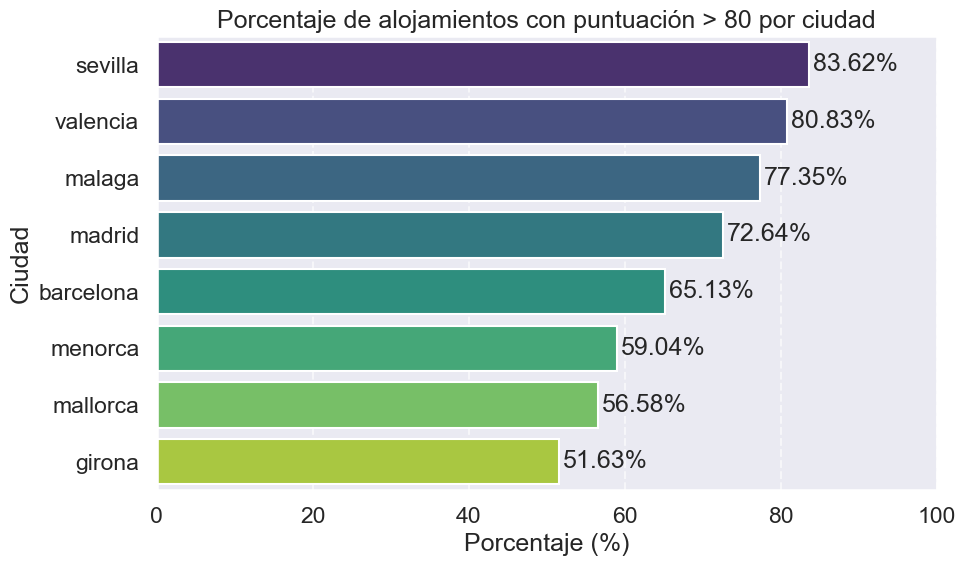

In [382]:
plt.figure(figsize=(10, 6))
sns.barplot(data=porcentaje_por_ciudad, x='supera_80', y='city', palette='viridis')

# Anotar porcentajes
for idx, row in enumerate(porcentaje_por_ciudad.itertuples()):
    plt.text(row.supera_80 + 0.5, idx, f"{row.supera_80}%", va='center')

# Ajustes visuales
plt.title('Porcentaje de alojamientos con puntuación > 80 por ciudad')
plt.xlabel('Porcentaje (%)')
plt.ylabel('Ciudad')
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Preguntas de negocio Sprint 2

## Operaciones

### Quin impacte té l'opció de reservar automàticament (sense revisió del propietari) a la disponibilitat mitjana a cada ciutat?

In [383]:
df_Book = df.groupby(['city', 'is_instant_bookable'])[['availability_30', 'availability_60', 'availability_90', 'availability_365']].mean().reset_index()
pivot_df_Book = df_Book.pivot(index='city', columns='is_instant_bookable', values=['availability_30', 'availability_60', 'availability_90', 'availability_365'])

In [384]:
pivot_df_Book.columns = ['{}_{}'.format(col[0], col[1]) for col in pivot_df_Book.columns]

# 2. Renombrar las columnas a nombres más descriptivos
pivot_df_Book = pivot_df_Book.rename(columns={
    'availability_30_VERDADERO': 'Disponibilidad 30 días (con reserva instantánea)',
    'availability_30_FALSO': 'Disponibilidad 30 días (sin reserva instantánea)',
    'availability_60_VERDADERO': 'Disponibilidad 60 días (con reserva instantánea)',
    'availability_60_FALSO': 'Disponibilidad 60 días (sin reserva instantánea)',
    'availability_90_VERDADERO': 'Disponibilidad 90 días (con reserva instantánea)',
    'availability_90_FALSO': 'Disponibilidad 90 días (sin reserva instantánea)',
    'availability_365_VERDADERO': 'Disponibilidad 365 días (con reserva instantánea)',
    'availability_365_FALSO': 'Disponibilidad 365 días (sin reserva instantánea)'
})


pivot_df_Book.round(2)

,Disponibilidad 30 días (sin reserva instantánea),Disponibilidad 30 días (con reserva instantánea),Disponibilidad 60 días (sin reserva instantánea),Disponibilidad 60 días (con reserva instantánea),Disponibilidad 90 días (sin reserva instantánea),Disponibilidad 90 días (con reserva instantánea),Disponibilidad 365 días (sin reserva instantánea),Disponibilidad 365 días (con reserva instantánea)
city,,,,,,,,
barcelona,11.37,11.03,25.78,26.05,42.33,43.77,178.53,192.06
girona,16.69,13.05,35.41,27.98,54.99,43.18,233.11,167.68
madrid,10.64,10.89,23.55,25.88,38.31,43.13,157.36,172.79
malaga,12.66,12.44,28.96,28.87,48.22,47.53,199.57,203.92
mallorca,13.30,13.46,28.72,28.68,45.69,44.94,214.99,208.14
menorca,15.58,13.69,31.81,29.06,48.68,45.64,213.56,182.60
sevilla,13.36,14.55,29.76,31.81,48.60,51.48,191.66,201.05
valencia,13.58,12.16,29.83,27.23,47.36,44.81,184.97,173.47


In [385]:
# Coeficiente de disponibilidad
pivot_df_Book['Coeficiente (30 días)'] = (
    pivot_df_Book['Disponibilidad 30 días (sin reserva instantánea)'] - 
    pivot_df_Book['Disponibilidad 30 días (con reserva instantánea)']
) / (
    pivot_df_Book['Disponibilidad 30 días (con reserva instantánea)'] + 
    pivot_df_Book['Disponibilidad 30 días (sin reserva instantánea)']
)

pivot_df_Book['Coeficiente (60 días)'] = (
    pivot_df_Book['Disponibilidad 60 días (sin reserva instantánea)'] - 
    pivot_df_Book['Disponibilidad 60 días (con reserva instantánea)']
) / (
    pivot_df_Book['Disponibilidad 60 días (con reserva instantánea)'] + 
    pivot_df_Book['Disponibilidad 60 días (sin reserva instantánea)']
)

pivot_df_Book['Coeficiente (90 días)'] = (
    pivot_df_Book['Disponibilidad 90 días (sin reserva instantánea)'] - 
    pivot_df_Book['Disponibilidad 90 días (con reserva instantánea)']
) / (
    pivot_df_Book['Disponibilidad 90 días (con reserva instantánea)'] + 
    pivot_df_Book['Disponibilidad 90 días (sin reserva instantánea)']
)

pivot_df_Book['Coeficiente (365 días)'] = (
    pivot_df_Book['Disponibilidad 365 días (sin reserva instantánea)'] - 
    pivot_df_Book['Disponibilidad 365 días (con reserva instantánea)']
) / (
    pivot_df_Book['Disponibilidad 365 días (con reserva instantánea)'] + 
    pivot_df_Book['Disponibilidad 365 días (sin reserva instantánea)']
)

In [386]:
pivot_df_Book[["Coeficiente (30 días)","Coeficiente (60 días)","Coeficiente (90 días)","Coeficiente (365 días)"]].round(2)

,Coeficiente (30 días),Coeficiente (60 días),Coeficiente (90 días),Coeficiente (365 días)
city,,,,
barcelona,0.02,-0.01,-0.02,-0.04
girona,0.12,0.12,0.12,0.16
madrid,-0.01,-0.05,-0.06,-0.05
malaga,0.01,0.00,0.01,-0.01
mallorca,-0.01,0.00,0.01,0.02
menorca,0.06,0.05,0.03,0.08
sevilla,-0.04,-0.03,-0.03,-0.02
valencia,0.06,0.05,0.03,0.03


In [387]:
# Generar las posiciones para cada ciudad
ind = np.arange(len(pivot_df_Book))  

# Extraer los coeficientes para cada período
coef30 = pivot_df_Book['Coeficiente (30 días)']
coef60 = pivot_df_Book['Coeficiente (60 días)']
coef90 = pivot_df_Book['Coeficiente (90 días)']
coef365 = pivot_df_Book['Coeficiente (365 días)']

fig = go.Figure()

# Añadir cada grupo de barras con colores específicos
fig.add_trace(go.Bar(
    x=pivot_df_Book.index,
    y=coef30,
    name='30 días',
    marker_color='#ADD8E6'  # Azul claro
))

fig.add_trace(go.Bar(
    x=pivot_df_Book.index,
    y=coef60,
    name='60 días',
    marker_color='#87CEEB'  # Azul cielo
))

fig.add_trace(go.Bar(
    x=pivot_df_Book.index,
    y=coef90,
    name='90 días',
    marker_color='#4682B4'  # Azul acero
))

fig.add_trace(go.Bar(
    x=pivot_df_Book.index,
    y=coef365,
    name='365 días',
    marker_color='#00008B'  # Azul oscuro
))

fig.update_layout(
    title='Coeficiente por Ciudad y Período',
    xaxis_title='Ciudad',
    yaxis_title='Coeficiente',
    barmode='group',  # Agrupar las barras
    yaxis=dict(range=[-0.2, 0.2]),  # Ajustar el rango del eje Y
    plot_bgcolor='rgba(0,0,0,0)',  # Fondo transparente
    legend=dict(title='Período', font=dict(size=12))
)

# Añadir una línea horizontal en y=0
fig.add_shape(type='line',
              x0=0, x1=1, y0=0, y1=0,
              xref='paper', yref='y',
              line=dict(color='black', width=1))

fig.show()

In [388]:
# Agrupar los datos por ciudad y calcular cuántos pisos tienen reservas automáticas y cuántos no
tabla_resumen_Book = df.groupby(['city', 'is_instant_bookable']).size().unstack(fill_value=0)

# Renombrar las columnas 
tabla_resumen_Book.columns = ['Sin Reserva Automática', 'Con Reserva Automática']

# Recalcular las columnas de porcentaje
tabla_resumen_Book['% Con Reserva Automática'] = (tabla_resumen_Book['Con Reserva Automática'] / tabla_resumen_Book[['Sin Reserva Automática', 'Con Reserva Automática']].sum(axis=1)) * 100
tabla_resumen_Book['% Sin Reserva Automática'] = (tabla_resumen_Book['Sin Reserva Automática'] / tabla_resumen_Book[['Sin Reserva Automática', 'Con Reserva Automática']].sum(axis=1)) * 100

# Aplicar estilo con formato para porcentajes redondeados y con símbolo %
tabla_resumen_Book_styled = tabla_resumen_Book[['% Con Reserva Automática', '% Sin Reserva Automática']].style.format({
    '% Con Reserva Automática': '{:.2f}%',  # 2 decimales con símbolo %
    '% Sin Reserva Automática': '{:.2f}%'   # 2 decimales con símbolo %
}).background_gradient(cmap='Blues')  # Añadir gradiente de color

tabla_resumen_Book_styled


,% Con Reserva Automática,% Sin Reserva Automática
city,,
barcelona,46.72%,53.28%
girona,59.40%,40.60%
madrid,55.88%,44.12%
malaga,69.47%,30.53%
mallorca,59.67%,40.33%
menorca,53.01%,46.99%
sevilla,68.24%,31.76%
valencia,50.83%,49.17%


In [389]:
tabla_resumen_Book

,Sin Reserva Automática,Con Reserva Automática,% Con Reserva Automática,% Sin Reserva Automática
city,,,,
barcelona,1201,1053,46.716948,53.283052
girona,486,711,59.398496,40.601504
madrid,724,917,55.880561,44.119439
malaga,120,273,69.465649,30.534351
mallorca,509,753,59.667195,40.332805
menorca,78,88,53.012048,46.987952
sevilla,128,275,68.238213,31.761787
valencia,177,183,50.833333,49.166667


In [390]:
valores_unicos = df["is_instant_bookable"].unique()
valores_unicos

array(['FALSO', 'VERDADERO'], dtype=object)

In [391]:
# Calcular la tasa de ocupación promedio mensual por ciudad y por opción de reserva instantánea
occupancy_by_city_instant_booking = df.groupby(['city', 'is_instant_bookable'])['occupancy_rate'].mean().reset_index()

instant_booking = occupancy_by_city_instant_booking[occupancy_by_city_instant_booking['is_instant_bookable'] == 'True']
non_instant_booking = occupancy_by_city_instant_booking[occupancy_by_city_instant_booking['is_instant_bookable'] == 'False']

# Comparar la tasa de ocupación promedio entre las dos categorías
print("Tasa de ocupación promedio por ciudad con y sin reserva instantánea:")
occupancy_by_city_instant_booking

Tasa de ocupación promedio por ciudad con y sin reserva instantánea:


,city,is_instant_bookable,occupancy_rate
0,barcelona,FALSO,62.087150
1,barcelona,VERDADERO,63.238367
2,girona,FALSO,44.382716
3,girona,VERDADERO,56.516643
4,madrid,FALSO,64.525783
5,madrid,VERDADERO,63.711378
6,malaga,FALSO,57.805556
7,malaga,VERDADERO,58.547009
8,mallorca,FALSO,55.677800
9,mallorca,VERDADERO,55.130589


In [392]:
occupancy_matrix = occupancy_by_city_instant_booking.pivot(index='city', columns='is_instant_bookable', values='occupancy_rate')

occupancy_matrix.rename(columns={'True': 'Instant Booking', 'False': 'No Instant Booking'}, inplace=True)

occupancy_matrix = occupancy_matrix.round(2)

# Función para formatear los valores con '%'
def add_percentage_format(df):
    return df.map(lambda x: f"{x:.2f}%" if x != 0 else "0%")

occupancy_matrix = add_percentage_format(occupancy_matrix)

# Función para resaltar el mayor y menor valor por fila
def highlight_min_max(s):
    styles = []
    for v in s:
        # Quitar el '%' para comparar los valores numéricos
        value = float(v.strip('%'))
        if value == max(float(v.strip('%')) for v in s):
            styles.append('background-color: darkblue; color: white;')
        elif value == min(float(v.strip('%')) for v in s):
            styles.append('background-color: lightblue; color: black;')
        else:
            styles.append('')
    return styles

styled_matrix = occupancy_matrix.style.apply(highlight_min_max, axis=1)

styled_matrix


is_instant_bookable,FALSO,VERDADERO
city,,
barcelona,62.09%,63.24%
girona,44.38%,56.52%
madrid,64.53%,63.71%
malaga,57.81%,58.55%
mallorca,55.68%,55.13%
menorca,48.08%,54.36%
sevilla,55.47%,51.49%
valencia,54.73%,59.47%


## Marketing

### Quines característiques dels allotjaments (comoditats, capacitat i puntuació de la zona) estan més relacionades amb els preus a cada ciutat?


### 1. Análisis de correlación general por ciudad
    Esto dará, para cada ciudad, qué variables tienen mayor correlación con el precio.

In [393]:
# Seleccionem les columnes rellevants
columnes_interessants = ['city', 'price', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 'review_scores_location']
df_corr = df[columnes_interessants].dropna()

# Calcular la correlació per ciutat
for ciutat in df_corr['city'].unique():
    print(f"\n📍 Ciutat: {ciutat.upper()}")
    sub_df = df_corr[df_corr['city'] == ciutat]
    correlacions = sub_df.corr(numeric_only=True)['price'].drop('price').sort_values(ascending=False)
    print(correlacions)


📍 Ciutat: GIRONA
accommodates              0.619896
beds                      0.590165
review_scores_location    0.018369
Name: price, dtype: float64

📍 Ciutat: MENORCA
accommodates              0.606815
beds                      0.401075
review_scores_location    0.085211
Name: price, dtype: float64

📍 Ciutat: MALAGA
accommodates              0.503006
beds                      0.458147
review_scores_location    0.081434
Name: price, dtype: float64

📍 Ciutat: SEVILLA
accommodates              0.340390
beds                      0.290387
review_scores_location    0.100226
Name: price, dtype: float64

📍 Ciutat: VALENCIA
beds                      0.471189
accommodates              0.464318
review_scores_location    0.064455
Name: price, dtype: float64

📍 Ciutat: MALLORCA
accommodates              0.619133
beds                      0.554947
review_scores_location   -0.025485
Name: price, dtype: float64

📍 Ciutat: BARCELONA
accommodates              0.641780
beds                      0.5948

### Idem anterior corrección comentarios Abelardo
    Este código:
    1.- Transforma amenities_list a una variable numérica (amenities_count).

    2.- Filtra columnas relevantes.

    3.- Calcula la correlación entre el price y las demás variables, por ciudad.

    4.- Ordena los resultados para ver cuál variable está más correlacionada con el precio en cada ciudad.

In [394]:
# Crear nueva columna numérica a partir de amenities_list
#df['amenities_count'] = df['amenities_list'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)

# Asegura que todo sea string antes de contar
#df['amenities_count'] = df['amenities_list'].apply(lambda x: len(str(x).split(',')) if pd.notnull(x) else 0)

# Solución robusta y segura: cubre todos los casos posibles: None, float('nan'), strings, listas reales, etc.
def contar_amenities(x):
    if isinstance(x, list):  # Si ya es lista
        return len(x)
    elif isinstance(x, str):  # Si es string
        return len(x.split(','))
    else:
        return 0

df['amenities_count'] = df['amenities_list'].apply(contar_amenities)

# Columnas que queremos correlacionar con el precio
columnes_interessants = ['city', 'price', 'accommodates', 'amenities_count', 'review_scores_location']
df_corr = df[columnes_interessants].dropna()

# Calcular la correlació per ciutat
for ciutat in df_corr['city'].unique():
    print(f"\n📍 Ciutat: {ciutat.upper()}")
    sub_df = df_corr[df_corr['city'] == ciutat]
    correlacions = sub_df.corr(numeric_only=True)['price'].drop('price').sort_values(ascending=False)
    print(correlacions)


📍 Ciutat: GIRONA
accommodates              0.620717
amenities_count           0.094901
review_scores_location    0.017305
Name: price, dtype: float64

📍 Ciutat: MENORCA
accommodates              0.605808
amenities_count           0.104645
review_scores_location    0.093744
Name: price, dtype: float64

📍 Ciutat: MALAGA
accommodates              0.503469
amenities_count           0.106369
review_scores_location    0.078533
Name: price, dtype: float64

📍 Ciutat: SEVILLA
accommodates              0.342267
review_scores_location    0.097902
amenities_count          -0.048515
Name: price, dtype: float64

📍 Ciutat: VALENCIA
accommodates              0.464289
review_scores_location    0.063881
amenities_count           0.001230
Name: price, dtype: float64

📍 Ciutat: MALLORCA
accommodates              0.619172
amenities_count           0.113876
review_scores_location   -0.025899
Name: price, dtype: float64

📍 Ciutat: BARCELONA
accommodates              0.643768
amenities_count           0.2073

### Paso 1: Calcular correlación por ciudad (capacidad, camas, puntuación de zona)

In [395]:
# Utilizaremos la nueva columna numérica a partir de amenities_list creada en el punto anterior.

# Variables a analizar incluyendo amenities_count creado en el punto anterior
vars_interes = ['accommodates', 'amenities_count', 'review_scores_location']

# Crear un DataFrame vacío para guardar las correlaciones
correlations_by_city = pd.DataFrame()

# Calcular correlaciones por ciudad
for city in df['city'].dropna().unique():
    sub_df = df[df['city'] == city]
    
    # Verificamos que haya suficientes datos válidos para calcular correlaciones
    if sub_df[vars_interes + ['price']].dropna().shape[0] >= 2:
        corr = sub_df[vars_interes + ['price']].corr(numeric_only=True)['price'].drop('price')
        correlations_by_city[city.upper()] = corr

# Transponer para que las ciudades queden como índice
correlations_by_city = correlations_by_city.T

# Ordenar por nombre de ciudad
correlations_by_city = correlations_by_city.sort_index()

# Mostrar el DataFrame
print(correlations_by_city)


           accommodates  amenities_count  review_scores_location
BARCELONA      0.624560         0.193934                0.004322
GIRONA         0.607425         0.081934                0.017305
MADRID         0.519546         0.122266                0.135324
MALAGA         0.495145         0.070803                0.078533
MALLORCA       0.583495         0.068516               -0.025899
MENORCA        0.621562         0.053228                0.093744
SEVILLA        0.350366        -0.078981                0.097902
VALENCIA       0.450751        -0.033583                0.063881


### Paso 2: Visualizar tabla con fondo de color dinámico

In [396]:
styled_corr = correlations_by_city.style\
    .background_gradient(cmap='YlGnBu')\
    .format("{:.2f}")\
    .set_caption("📊 Correlació entre característiques i preu per ciutat")

styled_corr

,accommodates,amenities_count,review_scores_location
BARCELONA,0.62,0.19,0.00
GIRONA,0.61,0.08,0.02
MADRID,0.52,0.12,0.14
MALAGA,0.50,0.07,0.08
MALLORCA,0.58,0.07,-0.03
MENORCA,0.62,0.05,0.09
SEVILLA,0.35,-0.08,0.10
VALENCIA,0.45,-0.03,0.06


###  2. Análisis de comodidades (“amenities”) relacionadas con el precio
    Podemos analizar si ciertos servicios (como WiFi, aire acondicionado, parking, etc.) están asociados a precios más altos. Suponiendo que normalized_amenities es una lista:

### Código para crear normalized_amenities

In [397]:
# Función de limpieza básica
def limpiar_amenities(x):
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return ''
    elif isinstance(x, list):
        items = x
    elif isinstance(x, str):
        items = [i.strip() for i in x.split(',')]
    else:
        return ''
    
    # Normalizar: quitar espacios, convertir a minúsculas, eliminar duplicados y ordenar
    items = [i.strip().lower() for i in items]
    return ', '.join(sorted(set(items)))

# Crear columna 'normalized_amenities'
df['normalized_amenities'] = df['amenities_list'].apply(limpiar_amenities)

In [398]:
# Creamos una matriz binaria de presencia/ausencia de comodidades
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(", "))
amenities_matrix = vectorizer.fit_transform(df['normalized_amenities'].fillna(''))

# Convertir a DataFrame
amenities_df = pd.DataFrame(amenities_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Añadir la columna de precio
amenities_df['price'] = df['price'].values

# Correlación entre cada amenity y el precio
correlacions_amenities = amenities_df.corr(numeric_only=True)['price'].drop('price').sort_values(ascending=False)

# Mostrar los 10 amenities con mayor correlación positiva con el precio
print("\n🏷️ Comoditats amb més correlació positiva amb el preu:")
print(correlacions_amenities.head(15))



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'




🏷️ Comoditats amb més correlació positiva amb el preu:
pool                        0.409685
indoor fireplace            0.300655
free parking on premises    0.294936
bbq grill                   0.244572
high chair                  0.243564
crib                        0.232296
dishwasher                  0.219892
tv                          0.216366
garden or backyard          0.215487
family/kid friendly         0.201343
washer                      0.175520
dryer                       0.175243
cable tv                    0.169666
air conditioning            0.163095
bathtub                     0.157703
Name: price, dtype: float64


### Código para estilizar las correlaciones de amenities con el precio:

In [399]:
# Crear un DataFrame de correlación para las comodidades
styled_amenities = correlacions_amenities.head(15).to_frame().reset_index()
styled_amenities.columns = ['Amenity', 'Correlación con el precio']

# Aplicar estilo
styled_amenities = styled_amenities.style\
    .background_gradient(subset=['Correlación con el precio'], cmap='YlGnBu')\
    .format({'Correlación con el precio': "{:.2f}"})\
    .set_caption("🏷️ Comoditats amb més correlació amb el preu (15 primeres)")

# Mostrar el estilo
styled_amenities

,Amenity,Correlación con el precio
0,pool,0.41
1,indoor fireplace,0.30
2,free parking on premises,0.29
3,bbq grill,0.24
4,high chair,0.24
5,crib,0.23
6,dishwasher,0.22
7,tv,0.22
8,garden or backyard,0.22
9,family/kid friendly,0.20


### Paso 3: Calcular correlación entre comodidades y precio

In [400]:
# Limpiar datos y crear la matriz de comodidades
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(", "))
amenities_matrix = vectorizer.fit_transform(df['normalized_amenities'].fillna(''))

# Convertir a DataFrame
amenities_df = pd.DataFrame(amenities_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Añadir precios
amenities_df['price'] = df['price'].values

# Calcular correlación
correlation_series = amenities_df.corr()['price'].drop('price').sort_values(ascending=False)

# Convertir a DataFrame para visualización
amenities_corr_df = correlation_series.reset_index()
amenities_corr_df.columns = ['Amenidad', 'Correlación con el precio']

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



### Paso 4: Mostrar tabla formateada (comodidades)

In [401]:
styled_amenities = amenities_corr_df.sort_values(by='Correlación con el precio', ascending=False).head(15).style\
    .background_gradient(subset=['Correlación con el precio'], cmap='Oranges')\
    .format({'Correlación con el precio': "{:.2f}"})\
    .set_caption("🛋️ Comoditats amb més correlació amb el preu (15 primeres)")

styled_amenities

,Amenidad,Correlación con el precio
0,pool,0.41
1,indoor fireplace,0.30
2,free parking on premises,0.29
3,bbq grill,0.24
4,high chair,0.24
5,crib,0.23
6,dishwasher,0.22
7,tv,0.22
8,garden or backyard,0.22
9,family/kid friendly,0.20


## Clientes

### Quins aspectes (precisió de detalls, higiene, check-in o comunicació) presenten diferències més grans entre els allotjaments millor i pitjor valorats en l'avaluació general?

El aspecto con la valoración más dispar es: Precisión    80.0
Limpieza     80.0
dtype: float64 con una diferencia de 80.00 puntos


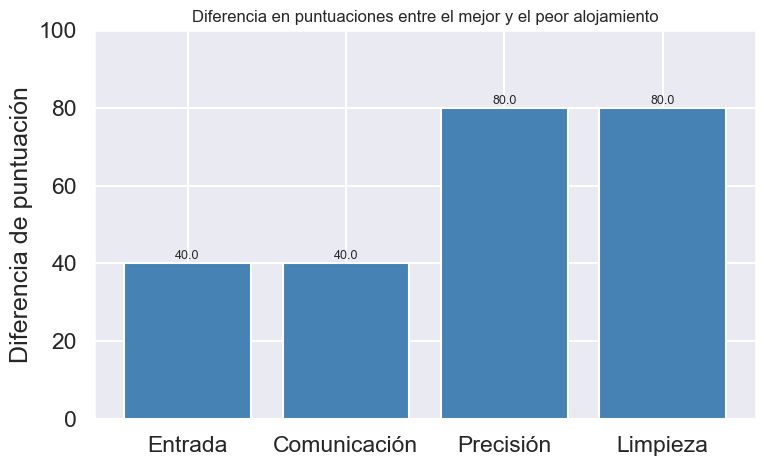

In [414]:
# Seleccionamos las características evaluadas que nos interesan, eliminando localización    
cols.remove('review_scores_location')

# Eliminar filas con valores nulos en estas columnas y en la puntuación global
df_clean = df.dropna(subset=cols + ['review_scores_value'])

# Calculamos el valor más habitual de cada característica por puntuación global
df_mediana = df_clean.groupby('review_scores_value')[cols].median().reset_index()
df_mediana

# Identificamos la valoración más alta y más baja de los alojamientos
mejor = df_mediana.loc[df_mediana['review_scores_value'].idxmax()]
peor = df_mediana.loc[df_mediana['review_scores_value'].idxmin()]

# Calcular diferencias
diferencias = (mejor[cols] - peor[cols]).sort_values().rename(traducciones)

max_diferencia = diferencias.max()
max_items = diferencias[diferencias == max_diferencia]

print(f"El aspecto con la valoración más dispar es: {max_items} con una diferencia de {max_diferencia:.2f} puntos")

# Gráfico
plt.figure(figsize=(8, 5))
bars = plt.bar(diferencias.index, diferencias.values, color='steelblue')
plt.title('Diferencia en puntuaciones entre el mejor y el peor alojamiento', fontsize=12)
plt.ylabel('Diferencia de puntuación')
plt.ylim(0, 100)

# Etiquetas encima de las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.3, f'{yval:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()


In [415]:
# Gráfica de radar plotly
#Trazamos la gráfica de radar

fig = px.line_polar(df, r=diferencias.values, theta=diferencias.index, range_r=(0, 100), line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(title_text='Diferencia global de valoraciones', title_x=0.5)

#Añadimos los valores

fig.add_trace(go.Scatterpolar(
    r=diferencias.values,
    theta=diferencias.index,
    mode='markers+text',
    marker=dict(color='blue', size=5, symbol='circle'),
    text=diferencias.values,
    textposition='top center',
    name='Valores',
    showlegend=False
))

#Marcamos el valor máximo

fig.add_trace(go.Scatterpolar(
    r=max_items.values,
    theta=max_items.index,
    mode='markers',
    marker=dict(color='red', size=10, symbol='circle'),
    name='Valor máximo',
    showlegend=False
))

Segmentamos por ciudad

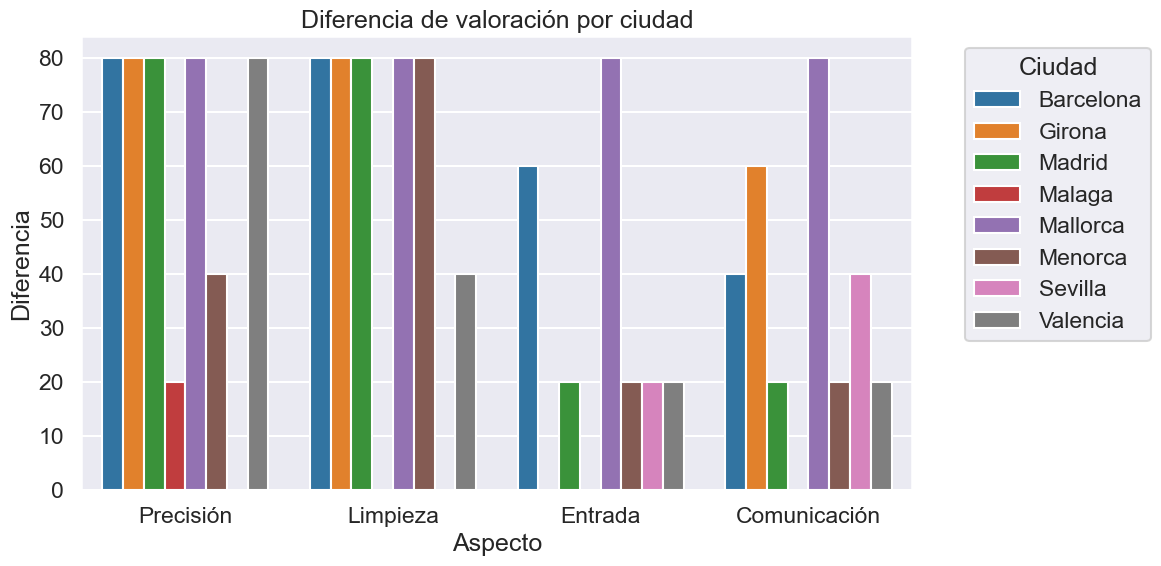

In [417]:
# Filtrar filas con datos completos
df_clean = df.dropna(subset=cols + ['review_scores_value', 'city'])

# Agrupar por ciudad
grouped = df_clean.groupby('city') #Gráfica de barras apilada

#Agrupar por ciudad y calcular diferencias
records = []
for city, group in df_clean.groupby('city'):
    mejor = group.loc[group['review_scores_rating'].idxmax()]
    peor = group.loc[group['review_scores_rating'].idxmin()]
    diferencias = (mejor[cols] - peor[cols]).rename(traducciones)
    for aspecto, valor in diferencias.items():
        records.append({
            'Ciudad': city.capitalize(),
            'Aspecto': aspecto,
            'Diferencia': valor
        })

# Crear DataFrame en formato largo
long_df = pd.DataFrame(records)

# Crear gráfica
plt.figure(figsize=(12, 6))
sns.barplot(data=long_df, x='Aspecto', y='Diferencia', hue='Ciudad')

# Ajustes estéticos
plt.title("Diferencia de valoración por ciudad")
plt.ylabel("Diferencia")
plt.legend(title="Ciudad", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Segmentamos por tipo de alojamiento

In [431]:
# Filtrar filas con datos completos
df_clean = df.dropna(subset=cols + ['review_scores_value', 'room_type'])

# Agrupar solo por tipo de alojamiento
grouped = df_clean.groupby('room_type')

# Inicializar figura
fig = go.Figure()

# Añadir una traza por tipo de alojamiento
for room_type, group in grouped:
    mejor = group.loc[group['review_scores_value'].idxmax()]
    peor = group.loc[group['review_scores_value'].idxmin()]
    diferencias = (mejor[cols] - peor[cols]).rename(traducciones)

    # Etiquetas más limpias
    theta_labels = diferencias.index
    r_values = diferencias.values

    fig.add_trace(go.Scatterpolar(
        r=r_values,
        theta=theta_labels,
        fill='toself',
        name=room_type,
        mode='lines+markers',
        opacity=0.6  # Mejora la legibilidad al superponer
    ))

# Configuración del gráfico
fig.update_layout(
    autosize=False,
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, df_clean[cols].max().max()]
        )
    ),
    title="Diferencia de valoración por tipo de alojamiento",
    title_x=0.5,
    showlegend=True
)

fig.show()


# CSV

In [ ]:
df.to_csv("../Data/2025_04_22_Sprint02.csv", index=False)

In [ ]:
df

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,...,reviews_per_month,country,city,insert_date,amenities_normalized,days_occupied,occupancy_rate,supera_80,amenities_count,normalized_amenities
3656,17249166,Arquitecte gaudi,Nuevo apartamento c�ntrico con buenos acabados...,109461701,Roses,None,Entire home/apt,5,1,2,...,9.0,spain,girona,2021-02-27,"24-hour check-in, air conditioning, bathroom e...",30,100.000000,True,15,"bed linens, elevator, essentials, extra pillow..."
5770,23040910,Apartamento luminoso cerca del mar,Apartamento muy bonito a 200m de la playa y en...,17816909,Ciutadella de Menorca,None,Entire home/apt,4,1,1,...,3.0,spain,menorca,2021-02-27,"24-hour check-in, baby essentials, balcony, ba...",1,3.333333,True,24,"coffee maker, cooking basics, dedicated worksp..."
7894,31968299,Villenpark Playa Arena House Flamenco,House with incredible garden and beautiful vie...,173153149,Lloret de Mar,None,Entire home/apt,5,1,2,...,NaN,spain,girona,2021-02-27,"balcony, barbecue utensils, bathroom essential...",30,100.000000,False,15,"bbq grill, coffee maker, dishes and silverware..."
6749,26207763,Casa Flor.....somewhere different,"Built in the late 1950's, Casa Flor is a detac...",196976392,L'Escala,None,Entire home/apt,2,1,1,...,12.0,spain,girona,2021-02-27,"24-hour check-in, air conditioning, balcony, b...",30,100.000000,True,50,"barbecue utensils, bbq grill, bed linens, blue..."
4507,19236052,Apartment with garden & pool - 800 m Pals beac...,Description<br /><br /><br /><br /><br /><br /...,133933726,Pals,None,Entire home/apt,7,2,3,...,3.0,spain,girona,2021-02-27,"air conditioning, baby essentials, balcony, ba...",30,100.000000,False,24,"bathtub, bed linens, coffee maker, cooking bas..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,888635,Diagonal Av penthouse 2 terrace,This amazing penthouse is located on the corne...,2041901,la Dreta de l'Eixample,Eixample,Entire home/apt,6,2,2,...,NaN,spain,barcelona,2017-01-04,"air conditioning, bathroom essentials, bathroo...",30,100.000000,False,14,"air conditioning, cable tv, dryer, elevator in..."
3323,16166606,"Relax y tranquilidad junto al parque, en Gracia",En Gracia. Sol y luz. Exterior. Junto a un paq...,15079254,el Putxet i el Farr�,Sarri�-Sant Gervasi,Entire home/apt,3,1,2,...,NaN,spain,barcelona,2017-01-04,"air conditioning, bathroom essentials, bathroo...",30,100.000000,False,12,"elevator in building, essentials, family/kid f..."
3188,15695052,Wonderful room in the heart of BCN,Wonderful bedroom located in the heart of Barc...,958218,el Raval,Ciutat Vella,Private room,1,1,1,...,82.0,spain,barcelona,2017-01-04,"24-hour check-in, air conditioning, bathroom e...",1,3.333333,False,23,"24-hour check-in, air conditioning, buzzer/wir..."
2066,11198148,Habitaci�n en Sagrada Fam�lia,"El piso es muy agradable, acogedor, muy lumino...",58197742,la Sagrada Fam�lia,Eixample,Private room,1,2,1,...,NaN,spain,barcelona,2017-01-04,"24-hour check-in, air conditioning, buzzer/wir...",10,33.333333,False,10,"24-hour check-in, buzzer/wireless intercom, el..."
